In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

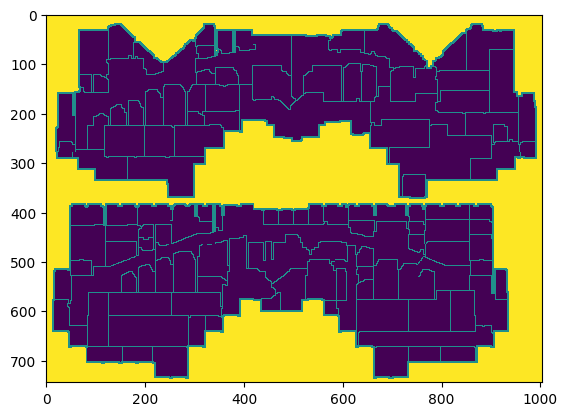

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
import gc
warnings.filterwarnings('ignore')

# GPU memory management
def clear_gpu_memory():
    """Clear GPU memory cache"""
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
    except ImportError:
        pass
    
    # Force garbage collection
    gc.collect()

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with Grouped PCA...")

# ===== MODEL WITH GROUPED PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, components_per_group=5):
        self.use_gpu = use_gpu
        self.components_per_group = components_per_group
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.group_pcas = {}  # Will store PCA transformers for each group
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_groups = {}  # Will store feature group definitions
        self.exog_feature_names = None  # Will store original exogenous feature names
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def create_device_to_zone_mapping(self):
        """Create mapping from device IDs to zone IDs using metadata"""
        device_to_zone = {}
        
        # Check if we have zone info available
        if 'metadata' in globals() and 'zone_infos' in metadata:
            zone_infos = metadata['zone_infos']
            print(f"Found {len(zone_infos)} zones in metadata")
            
            for zone_info in zone_infos:
                zone_id = zone_info.get('zone_id', 'unknown_zone')
                zone_description = zone_info.get('zone_description', zone_id)
                devices = zone_info.get('devices', [])
                
                # Map each device to this zone
                for device_id in devices:
                    device_to_zone[device_id] = {
                        'zone_id': zone_id,
                        'zone_description': zone_description,
                        'floor': zone_info.get('floor', 0),
                        'zone_type': zone_info.get('zone_type', 0)
                    }
            
            print(f"Mapped {len(device_to_zone)} devices to zones")
        else:
            print("No zone metadata found, using device-based grouping as fallback")
        
        return device_to_zone
    
    def create_feature_groups(self, exog_data, exog_metadata_dict):
        """Create feature groups based on actual zones and domain knowledge"""
        print("Creating zone-aware feature groups using actual zone metadata...")
        
        # Create device to zone mapping
        device_to_zone = self.create_device_to_zone_mapping()
        
        # Create feature names for mapping
        feature_names = []
        if isinstance(exog_metadata_dict, dict):
            name_to_idx = {name: idx for name, idx in exog_metadata_dict.items()}
            feature_names = list(name_to_idx.keys())
        else:
            feature_names = [f'feature_{i}' for i in range(exog_data.shape[1])]
        
        # Initialize zone-domain groups
        zone_domain_groups = {}
        
        print("Analyzing features and mapping to zones...")
        
        # Process each feature
        for i, feature_name in enumerate(feature_names):
            name_lower = feature_name.lower()
            
            # Extract device ID (before @ symbol)
            device_id = "unknown_device"
            if '@' in feature_name:
                device_id = feature_name.split('@')[0]
            
            # Map device to zone
            zone_info = device_to_zone.get(device_id, {
                'zone_id': f'device_{device_id}',
                'zone_description': f'Device_{device_id}',
                'floor': 0,
                'zone_type': 0
            })
            
            zone_id = zone_info['zone_id']
            
            # Determine domain
            domain = 'other'
            if any(keyword in name_lower for keyword in [
                'air_temperature', 'mixed_air_temperature', 
                'supply_air_temperature', 'return_air_temperature',
                'discharge_air_temperature', 'outside_air_temperature'
            ]):
                domain = 'air_temperatures'
            
            elif any(keyword in name_lower for keyword in [
                'water_temperature', 'supply_water_temperature',
                'return_water_temperature', 'hot_water', 'chilled_water'
            ]):
                domain = 'water_temperatures'
            
            elif any(keyword in name_lower for keyword in [
                'setpoint', '_setpoint', 'temperature_setpoint'
            ]):
                domain = 'setpoints'
            
            elif any(keyword in name_lower for keyword in [
                'command', 'percentage_command', 'damper', 'fan_speed',
                'valve', 'position', 'cooling', 'heating'
            ]):
                domain = 'control_commands'
            
            elif any(keyword in name_lower for keyword in [
                'outside_air', 'outdoor', 'ambient', 'humidity', 
                'dewpoint', 'wetbulb', 'pressure_sensor', 'static_pressure'
            ]):
                domain = 'environmental'
            
            elif any(keyword in name_lower for keyword in [
                'flow', 'flowrate', 'pressure', 'static', 'differential'
            ]):
                domain = 'flow_pressure'
            
            # Create zone-domain group name
            # Use zone description if available, otherwise zone_id
            zone_name = zone_info.get('zone_description', zone_id)
            # Clean zone name for group naming
            zone_name = zone_name.replace('/', '_').replace('-', '_').replace(' ', '_')
            group_name = f"{domain}_{zone_name}"
            
            # Add feature to group
            if group_name not in zone_domain_groups:
                zone_domain_groups[group_name] = []
            zone_domain_groups[group_name].append(i)
        
        # Also create building-wide groups for environmental features
        # These affect all zones similarly
        environmental_features = []
        for i, feature_name in enumerate(feature_names):
            name_lower = feature_name.lower()
            if any(keyword in name_lower for keyword in [
                'outside_air', 'outdoor', 'ambient', 'humidity', 
                'dewpoint', 'wetbulb'
            ]):
                environmental_features.append(i)
        
        if environmental_features:
            zone_domain_groups['environmental_building_wide'] = environmental_features
        
        # Filter out groups with too few features (less than 2)
        zone_domain_groups = {name: indices for name, indices in zone_domain_groups.items() 
                            if len(indices) >= 2}
        
        # Store the final groups
        self.feature_groups = zone_domain_groups
        
        # Print detailed group summary
        print(f"\nZone-aware feature groups created:")
        total_features = 0
        domain_counts = {}
        zone_counts = {}
        
        for group_name, indices in self.feature_groups.items():
            parts = group_name.split('_', 1)
            domain = parts[0] if len(parts) > 0 else 'unknown'
            zone = parts[1] if len(parts) > 1 else 'unknown'
            
            domain_counts[domain] = domain_counts.get(domain, 0) + len(indices)
            zone_counts[zone] = zone_counts.get(zone, 0) + 1
            
            total_features += len(indices)
        
        # Show sample of groups
        group_items = list(self.feature_groups.items())
        sample_size = min(10, len(group_items))
        print(f"  Sample groups (showing {sample_size} of {len(self.feature_groups)}):")
        for group_name, indices in group_items[:sample_size]:
            print(f"    {group_name}: {len(indices)} features")
        
        if len(group_items) > sample_size:
            print(f"    ... and {len(group_items) - sample_size} more groups")
        
        print(f"\nSummary:")
        print(f"  Total feature groups: {len(self.feature_groups)}")
        print(f"  Total features categorized: {total_features}/{exog_data.shape[1]}")
        print(f"  Features per domain: {dict(domain_counts)}")
        print(f"  Unique zones found: {len(set(zone_counts.keys()))}")
        print(f"  Average features per group: {total_features/len(self.feature_groups):.1f}")
        
        return self.feature_groups
    
    def fit_grouped_pca(self, exog_data, exog_metadata_dict):
        """Fit PCA separately for each zone-aware feature group"""
        print(f"\nFitting Zone-Aware Grouped PCA (max {self.components_per_group} components per group)...")
        
        # Create zone-aware feature groups
        self.create_feature_groups(exog_data, exog_metadata_dict)
        
        total_components = 0
        successful_groups = 0
        
        for group_name, feature_indices in self.feature_groups.items():
            if len(feature_indices) == 0:
                continue
                
            # Extract group data
            group_data = exog_data[:, feature_indices]
            
            # Determine number of components (min of requested and available)
            n_components = min(self.components_per_group, len(feature_indices), group_data.shape[0]-1)
            
            if n_components <= 0:
                print(f"  Skipping {group_name}: insufficient data")
                continue
            
            # Fit PCA for this group
            group_pca = PCA(n_components=n_components, random_state=42)
            group_pca.fit(group_data)
            
            self.group_pcas[group_name] = group_pca
            
            explained_variance = np.sum(group_pca.explained_variance_ratio_)
            total_components += n_components
            successful_groups += 1
            
            # Only print details for first few groups to avoid spam
            if successful_groups <= 10:
                print(f"  {group_name}: {len(feature_indices)} features → {n_components} components "
                      f"(explained variance: {explained_variance:.3f})")
            elif successful_groups == 11:
                print(f"  ... (showing first 10 groups, {len(self.feature_groups) - 10} more groups fitted)")
        
        print(f"\nZone-Aware Grouped PCA Summary:")
        print(f"  Original features: {exog_data.shape[1]}")
        print(f"  Total PCA components: {total_components}")
        print(f"  Successful feature groups: {successful_groups}")
        print(f"  Average components per group: {total_components/successful_groups:.1f}")
        print(f"  Dimensionality reduction: {exog_data.shape[1]} → {total_components}")
        print(f"  Reduction factor: {exog_data.shape[1]/total_components:.1f}x")
    
    def transform_grouped_pca(self, exog_data):
        """Transform exogenous data using fitted grouped PCA"""
        if not self.group_pcas:
            raise ValueError("Grouped PCA not fitted yet. Call fit_grouped_pca first.")
        
        transformed_groups = []
        group_feature_names = []
        
        for group_name, group_pca in self.group_pcas.items():
            # Get feature indices for this group
            feature_indices = self.feature_groups[group_name]
            
            # Extract and transform group data
            group_data = exog_data[:, feature_indices]
            group_transformed = group_pca.transform(group_data)
            
            transformed_groups.append(group_transformed)
            
            # Create feature names for this group
            n_components = group_transformed.shape[1]
            group_names = [f'{group_name}_pc{i}' for i in range(n_components)]
            group_feature_names.extend(group_names)
        
        # Combine all transformed groups
        if transformed_groups:
            combined_transformed = np.hstack(transformed_groups)
        else:
            combined_transformed = np.array([]).reshape(exog_data.shape[0], 0)
        
        return combined_transformed, group_feature_names
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, Grouped PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and Grouped PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and not self.group_pcas:
                # Fit Grouped PCA on training data
                # We need the metadata dict for feature grouping
                exog_metadata = exogenous_observation_data_ids if 'exogenous_observation_data_ids' in globals() else None
                self.fit_grouped_pca(exog_data_clean, exog_metadata)
            
            # Transform exogenous data using Grouped PCA
            exog_pca, exog_names = self.transform_grouped_pca(exog_data_clean)
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create 15-minute bins for data (96 bins total: 24 hours × 4 fifteen-minute periods)"""
        time_bins_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Calculate 15-minute time bin
            hour = dt.hour  # 0-23
            minute = dt.minute  # 0-59
            minute_bin = minute // 15  # 0-3 (0-14min=0, 15-29min=1, 30-44min=2, 45-59min=3)
            time_bin = hour * 4 + minute_bin  # 0-95 (96 total bins)
                
            if time_bin not in time_bins_data:
                time_bins_data[time_bin] = {'X': [], 'y': []}
            time_bins_data[time_bin]['X'].append(X[i])
            if y is not None:
                time_bins_data[time_bin]['y'].append(y[i])
        
        # Convert to numpy arrays
        for time_bin in time_bins_data:
            time_bins_data[time_bin]['X'] = np.array(time_bins_data[time_bin]['X'])
            if y is not None:
                time_bins_data[time_bin]['y'] = np.array(time_bins_data[time_bin]['y'])
        
        return time_bins_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        
        # Clear GPU memory before optimization
        clear_gpu_memory()
        
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),  # Reduced for memory
            'max_depth': trial.suggest_int('max_depth', 3, 6),  # Reduced for memory
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        # Add GPU-specific memory management parameters
        if self.use_gpu:
            params.update({
                'gpu_id': 0,
                'max_bin': 256,  # Reduce memory usage
                'single_precision_histogram': True  # Use less memory
            })
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            result = mean_absolute_error(y_val, y_pred)
            
            # Clear memory after each trial
            del model, base_model
            clear_gpu_memory()
            
            return result
            
        except Exception as e:
            print(f"Trial failed with error: {e}")
            clear_gpu_memory()
            return float('inf')  # Return worst possible score
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=5):
        """Train 96 fifteen-minute XGBoost models with hyperparameter optimization"""
        
        # Clear GPU memory before starting
        clear_gpu_memory()
        
        # Create 15-minute time bins (96 total)
        time_bins_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(time_bins_data)} fifteen-minute models (out of 96 possible)...")
        
        successful_models = 0
        for time_bin in range(96):  # 96 fifteen-minute periods in 24 hours
            if time_bin not in time_bins_data:
                hour = time_bin // 4
                minute_period = (time_bin % 4) * 15
                print(f"No data for time bin {time_bin} ({hour:02d}:{minute_period:02d}-{hour:02d}:{minute_period+14:02d}), skipping...")
                continue
                
            hour = time_bin // 4
            minute_period = (time_bin % 4) * 15
            print(f"Training model for time bin {time_bin} ({hour:02d}:{minute_period:02d}-{hour:02d}:{minute_period+14:02d})...")
            
            # Clear GPU memory before each model
            clear_gpu_memory()
            
            X_timebin = time_bins_data[time_bin]['X']
            y_timebin = time_bins_data[time_bin]['y']
            
            if len(X_timebin) < 10:
                print(f"Too few samples for time bin {time_bin} ({len(X_timebin)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_timebin_scaled = scaler.fit_transform(X_timebin)
            self.scalers[time_bin] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'timebin_{time_bin}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_timebin_scaled, y_timebin, trial)
            
            try:
                study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
                
                # Train final model with best parameters
                best_params = study.best_params
                best_params.update({
                    'objective': 'reg:absoluteerror',
                    'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                    'random_state': 42,
                    'n_jobs': 1
                })
                
                # Add GPU-specific parameters for final model
                if self.use_gpu:
                    best_params.update({
                        'gpu_id': 0,
                        'max_bin': 256,
                        'single_precision_histogram': True
                    })
                
                base_model = xgb.XGBRegressor(**best_params)
                model = MultiOutputRegressor(base_model, n_jobs=1)
                model.fit(X_timebin_scaled, y_timebin)
                
                self.models[time_bin] = model
                successful_models += 1
                
                print(f"Time bin {time_bin} ({hour:02d}:{minute_period:02d}-{hour:02d}:{minute_period+14:02d}) - Best MAE: {study.best_value:.4f}")
                
            except Exception as e:
                print(f"Error training time bin {time_bin}: {e}")
                print(f"Skipping time bin {time_bin}")
                continue
            
            # Clear memory after each time bin
            clear_gpu_memory()
        
        print(f"Training completed. {successful_models} fifteen-minute models trained out of {len(time_bins_data)} available time periods.")
        
        # Final memory cleanup
        clear_gpu_memory()
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using fifteen-minute models"""
        
        # Clear GPU memory before prediction
        clear_gpu_memory()
        
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create 15-minute time bins for test data
        time_bins_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for time_bin in time_bins_data:
            if time_bin not in self.models:
                # Find closest available time bin
                available_time_bins = list(self.models.keys())
                time_bin_to_use = min(available_time_bins, key=lambda x: abs(x - time_bin))
                hour = time_bin // 4
                minute_period = (time_bin % 4) * 15
                hour_to_use = time_bin_to_use // 4
                minute_period_to_use = (time_bin_to_use % 4) * 15
                print(f"Using model for time bin {time_bin_to_use} ({hour_to_use:02d}:{minute_period_to_use:02d}) instead of time bin {time_bin} ({hour:02d}:{minute_period:02d})")
            else:
                time_bin_to_use = time_bin
            
            X_timebin = time_bins_data[time_bin]['X']
            X_timebin_scaled = self.scalers[time_bin_to_use].transform(X_timebin)
            
            try:
                timebin_predictions = self.models[time_bin_to_use].predict(X_timebin_scaled)
                
                # Map predictions back to original indices
                timebin_indices = []
                for i, ts in enumerate(timestamps_test):
                    if hasattr(ts, 'hour'):  # pandas Timestamp
                        dt = ts
                    else:  # Unix timestamp
                        dt = datetime.fromtimestamp(ts)
                    
                    # Calculate 15-minute time bin for this timestamp
                    hour = dt.hour
                    minute = dt.minute
                    minute_bin = minute // 15
                    ts_time_bin = hour * 4 + minute_bin
                        
                    if ts_time_bin == time_bin:
                        timebin_indices.append(i)
                
                for i, idx in enumerate(timebin_indices):
                    predictions[idx] = timebin_predictions[i]
                    
            except Exception as e:
                hour = time_bin // 4
                minute_period = (time_bin % 4) * 15
                print(f"Error predicting for time bin {time_bin} ({hour:02d}:{minute_period:02d}): {e}")
                continue
        
        # Clear memory after prediction
        clear_gpu_memory()
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    # Clear GPU memory at start
    clear_gpu_memory()
    
    print("Initializing Smart Buildings Predictor with Zone-Aware Grouped PCA...")
    predictor = SmartBuildingsPredictor(use_gpu=True, components_per_group=3)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Debug: Check if feature count is reasonable
    if X_train.shape[1] > 500:
        print(f"WARNING: Large feature count ({X_train.shape[1]}). Consider reducing components_per_group.")
    elif X_train.shape[1] < 50:
        print(f"WARNING: Very small feature count ({X_train.shape[1]}). Consider increasing components_per_group.")
    
    # Clear memory before training
    clear_gpu_memory()
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=5)
    
    # Clear memory after training
    clear_gpu_memory()
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    # Final memory cleanup
    clear_gpu_memory()
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-07 12:51:05,987] A new study created in memory with name: timebin_0
[I 2025-07-07 12:52:11,832] Trial 0 finished with value: 1.783619339878611 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.25114338443712053, 'subsample': 0.7484540743134267, 'colsample_bytree': 0.6029673403255533, 'reg_alpha': 7.232936228553694, 'reg_lambda': 9.063633560920994}. Best is trial 0 with value: 1.783619339878611.
[I 2025-07-07 12:56:05,189] Trial 1 finished with value: 1.6828274393032525 and parameters: {'n_estimators': 267, 'max_depth': 6, 'learning_rate': 0.1148568043837944, 'subsample': 0.6984295686714826, 'colsample_bytree': 0.784794260926966, 'reg_alpha': 7.364291768878315, 'reg_lambda': 9.471775573746068}. Best is trial 1 with value: 1.6828274393032525.
[I 2025-07-07 12:58:22,824] Trial 2 finished with value: 2.1143847601560877 and parameters: {'n_estimators': 204, 'max_depth': 5, 'learning_rate': 0.03097020296412692, 'subsample': 0.6311686609725266, 'colsample_byt

Time bin 0 (00:00-00:14) - Best MAE: 1.5956


[I 2025-07-07 13:03:26,299] A new study created in memory with name: timebin_1


Training model for time bin 1 (00:15-00:29)...


[I 2025-07-07 13:04:41,436] Trial 0 finished with value: 1.6883203503455708 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.19184835389094, 'subsample': 0.645235014138314, 'colsample_bytree': 0.9281748507736342, 'reg_alpha': 2.551231433487073, 'reg_lambda': 6.675727687591845}. Best is trial 0 with value: 1.6883203503455708.
[I 2025-07-07 13:07:06,997] Trial 1 finished with value: 1.7176590840496804 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.0823889704481081, 'subsample': 0.6423995292425069, 'colsample_bytree': 0.6048885466743511, 'reg_alpha': 2.0321838781221104, 'reg_lambda': 4.00003368551919}. Best is trial 0 with value: 1.6883203503455708.
[I 2025-07-07 13:08:09,193] Trial 2 finished with value: 2.1037063017495377 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.05009427468662802, 'subsample': 0.9697571720893632, 'colsample_bytree': 0.6513456891566305, 'reg_alpha': 5.049965556811032, 'reg_lambda': 8.092204

Time bin 1 (00:15-00:29) - Best MAE: 1.6883
Training model for time bin 2 (00:30-00:44)...


[I 2025-07-07 13:13:38,188] A new study created in memory with name: timebin_2
[I 2025-07-07 13:15:27,653] Trial 0 finished with value: 1.681789061130151 and parameters: {'n_estimators': 124, 'max_depth': 5, 'learning_rate': 0.2739442631729998, 'subsample': 0.8355326403212587, 'colsample_bytree': 0.9330590054122506, 'reg_alpha': 9.154335624040542, 'reg_lambda': 0.6515173551234118}. Best is trial 0 with value: 1.681789061130151.
[I 2025-07-07 13:17:50,190] Trial 1 finished with value: 1.743181961742748 and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.04951846357133362, 'subsample': 0.754803214242348, 'colsample_bytree': 0.6222697881298792, 'reg_alpha': 8.23516436800709, 'reg_lambda': 8.641108633405459}. Best is trial 0 with value: 1.681789061130151.
[I 2025-07-07 13:19:17,821] Trial 2 finished with value: 1.671399383702175 and parameters: {'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.23966529700753103, 'subsample': 0.7088033130302487, 'colsample_bytree

Time bin 2 (00:30-00:44) - Best MAE: 1.6387


[I 2025-07-07 13:25:46,212] A new study created in memory with name: timebin_3


Training model for time bin 3 (00:45-00:59)...


[I 2025-07-07 13:27:20,333] Trial 0 finished with value: 1.662813246157542 and parameters: {'n_estimators': 189, 'max_depth': 4, 'learning_rate': 0.08997821649665838, 'subsample': 0.6119118886034067, 'colsample_bytree': 0.6035003100128321, 'reg_alpha': 0.24751639603684358, 'reg_lambda': 5.463370680043381}. Best is trial 0 with value: 1.662813246157542.
[I 2025-07-07 13:29:18,716] Trial 1 finished with value: 1.5352372148301865 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.169655951852269, 'subsample': 0.8900958751239476, 'colsample_bytree': 0.8651352576929937, 'reg_alpha': 1.7788132362062739, 'reg_lambda': 7.724897500335223}. Best is trial 1 with value: 1.5352372148301865.
[I 2025-07-07 13:32:29,397] Trial 2 finished with value: 1.500867334760409 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.20516734226924074, 'subsample': 0.6677407287092786, 'colsample_bytree': 0.7993396034816921, 'reg_alpha': 3.609712446258198, 'reg_lambda': 8.658

Time bin 3 (00:45-00:59) - Best MAE: 1.4843


[I 2025-07-07 13:40:26,889] A new study created in memory with name: timebin_4


Training model for time bin 4 (01:00-01:14)...


[I 2025-07-07 13:41:26,750] Trial 0 finished with value: 1.9127202211583343 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.2699185086390224, 'subsample': 0.9595346684595942, 'colsample_bytree': 0.6299267693244499, 'reg_alpha': 7.990742391367157, 'reg_lambda': 0.04310589754540859}. Best is trial 0 with value: 1.9127202211583343.
[I 2025-07-07 13:43:28,427] Trial 1 finished with value: 1.7769374462928365 and parameters: {'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.16044708697966545, 'subsample': 0.8171024349132074, 'colsample_bytree': 0.8010885416366774, 'reg_alpha': 4.3717277317298695, 'reg_lambda': 9.882606463047003}. Best is trial 1 with value: 1.7769374462928365.
[I 2025-07-07 13:45:25,044] Trial 2 finished with value: 1.9919218900858107 and parameters: {'n_estimators': 196, 'max_depth': 4, 'learning_rate': 0.04561093826784593, 'subsample': 0.8412828781187794, 'colsample_bytree': 0.9454375636433315, 'reg_alpha': 7.718615925481866, 'reg_lambda': 5

Time bin 4 (01:00-01:14) - Best MAE: 1.7769


[I 2025-07-07 13:51:56,440] A new study created in memory with name: timebin_5


Training model for time bin 5 (01:15-01:29)...


[I 2025-07-07 13:53:08,160] Trial 0 finished with value: 1.98013389315704 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.07469536744073957, 'subsample': 0.9684808388866044, 'colsample_bytree': 0.9666246323006615, 'reg_alpha': 7.610188138365885, 'reg_lambda': 9.524882115473805}. Best is trial 0 with value: 1.98013389315704.
[I 2025-07-07 13:54:27,566] Trial 1 finished with value: 1.9190428791157532 and parameters: {'n_estimators': 107, 'max_depth': 5, 'learning_rate': 0.1522995460571349, 'subsample': 0.8130183891168685, 'colsample_bytree': 0.6272236606361182, 'reg_alpha': 7.47072249526175, 'reg_lambda': 2.085275543131732}. Best is trial 1 with value: 1.9190428791157532.
[I 2025-07-07 13:56:47,836] Trial 2 finished with value: 1.826680269301395 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.07056915665575327, 'subsample': 0.9452774355551699, 'colsample_bytree': 0.7903729161600613, 'reg_alpha': 3.310070621627812, 'reg_lambda': 0.46749907

Time bin 5 (01:15-01:29) - Best MAE: 1.8267


[I 2025-07-07 14:01:02,386] A new study created in memory with name: timebin_6


Training model for time bin 6 (01:30-01:44)...


[I 2025-07-07 14:03:07,068] Trial 0 finished with value: 1.756916167838978 and parameters: {'n_estimators': 288, 'max_depth': 3, 'learning_rate': 0.27957958138138245, 'subsample': 0.7313324958196037, 'colsample_bytree': 0.9032309949882454, 'reg_alpha': 9.555890222006273, 'reg_lambda': 8.320469143919416}. Best is trial 0 with value: 1.756916167838978.
[I 2025-07-07 14:04:33,323] Trial 1 finished with value: 2.348013198662088 and parameters: {'n_estimators': 112, 'max_depth': 5, 'learning_rate': 0.03461650134820639, 'subsample': 0.7403035963082513, 'colsample_bytree': 0.7740981582000103, 'reg_alpha': 7.053242044864739, 'reg_lambda': 6.007541785031902}. Best is trial 0 with value: 1.756916167838978.
[I 2025-07-07 14:06:53,010] Trial 2 finished with value: 1.4963079283948102 and parameters: {'n_estimators': 247, 'max_depth': 4, 'learning_rate': 0.2621547414574582, 'subsample': 0.8584799847303686, 'colsample_bytree': 0.8162471461103342, 'reg_alpha': 0.3100543901424416, 'reg_lambda': 4.79815

Time bin 6 (01:30-01:44) - Best MAE: 1.4963


[I 2025-07-07 14:14:17,023] A new study created in memory with name: timebin_7


Training model for time bin 7 (01:45-01:59)...


[I 2025-07-07 14:18:17,684] Trial 0 finished with value: 1.4552189110481055 and parameters: {'n_estimators': 216, 'max_depth': 6, 'learning_rate': 0.2433038237219167, 'subsample': 0.9362284546788276, 'colsample_bytree': 0.8178137389841211, 'reg_alpha': 7.346590041214666, 'reg_lambda': 3.6321937089923972}. Best is trial 0 with value: 1.4552189110481055.
[I 2025-07-07 14:20:50,304] Trial 1 finished with value: 1.5679829949960258 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.25981080565318415, 'subsample': 0.7221653812555575, 'colsample_bytree': 0.6226196960650836, 'reg_alpha': 4.249529687136931, 'reg_lambda': 7.915991214473565}. Best is trial 0 with value: 1.4552189110481055.
[I 2025-07-07 14:22:41,516] Trial 2 finished with value: 1.6231361793300536 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.15589698976726102, 'subsample': 0.913072473487731, 'colsample_bytree': 0.927441636928939, 'reg_alpha': 6.756853664637124, 'reg_lambda': 0.506

Time bin 7 (01:45-01:59) - Best MAE: 1.4552


[I 2025-07-07 14:31:21,494] A new study created in memory with name: timebin_8


Training model for time bin 8 (02:00-02:14)...


[I 2025-07-07 14:33:15,787] Trial 0 finished with value: 1.8150066706750125 and parameters: {'n_estimators': 192, 'max_depth': 4, 'learning_rate': 0.18067235749117683, 'subsample': 0.9766604696613801, 'colsample_bytree': 0.8840867590202313, 'reg_alpha': 9.712098223839519, 'reg_lambda': 0.013037060572337738}. Best is trial 0 with value: 1.8150066706750125.
[I 2025-07-07 14:36:40,133] Trial 1 finished with value: 1.5125191426252593 and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.27418446796957535, 'subsample': 0.9751506902219246, 'colsample_bytree': 0.8300555591871619, 'reg_alpha': 4.312365842739331, 'reg_lambda': 7.4341493398088705}. Best is trial 1 with value: 1.5125191426252593.
[I 2025-07-07 14:39:45,080] Trial 2 finished with value: 1.6073995606153677 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.08587463261326633, 'subsample': 0.9340060853210919, 'colsample_bytree': 0.801521006984754, 'reg_alpha': 4.7302058097556765, 'reg_lambda':

Time bin 8 (02:00-02:14) - Best MAE: 1.5125


[I 2025-07-07 14:46:54,439] A new study created in memory with name: timebin_9


Training model for time bin 9 (02:15-02:29)...


[I 2025-07-07 14:47:52,732] Trial 0 finished with value: 2.006696851846758 and parameters: {'n_estimators': 161, 'max_depth': 3, 'learning_rate': 0.0644067573330837, 'subsample': 0.7459585143183525, 'colsample_bytree': 0.6948759774496704, 'reg_alpha': 0.2921717916060944, 'reg_lambda': 9.438928013259055}. Best is trial 0 with value: 2.006696851846758.
[I 2025-07-07 14:48:55,651] Trial 1 finished with value: 1.8227955973572876 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.12365292823085407, 'subsample': 0.7711904566240836, 'colsample_bytree': 0.646331023336966, 'reg_alpha': 3.7080309209079063, 'reg_lambda': 6.142895834758691}. Best is trial 1 with value: 1.8227955973572876.
[I 2025-07-07 14:51:05,234] Trial 2 finished with value: 1.6202883207337986 and parameters: {'n_estimators': 158, 'max_depth': 5, 'learning_rate': 0.10672020788157578, 'subsample': 0.8529256265589809, 'colsample_bytree': 0.9716537635460399, 'reg_alpha': 1.654405369935379, 'reg_lambda': 8.335

Time bin 9 (02:15-02:29) - Best MAE: 1.5227


[I 2025-07-07 14:56:55,132] A new study created in memory with name: timebin_10


Training model for time bin 10 (02:30-02:44)...


[I 2025-07-07 14:58:01,853] Trial 0 finished with value: 1.9772301415972295 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.13925119096067795, 'subsample': 0.6230319836239188, 'colsample_bytree': 0.9610706984671475, 'reg_alpha': 3.9606661212469465, 'reg_lambda': 7.1296215707618655}. Best is trial 0 with value: 1.9772301415972295.
[I 2025-07-07 14:59:58,473] Trial 1 finished with value: 1.6085318902960404 and parameters: {'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.28485764125080626, 'subsample': 0.9059601784618542, 'colsample_bytree': 0.8778629048146389, 'reg_alpha': 2.5412882561762946, 'reg_lambda': 0.9385204618575496}. Best is trial 1 with value: 1.6085318902960404.
[I 2025-07-07 15:01:03,288] Trial 2 finished with value: 1.6919891125211515 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.2998586251760074, 'subsample': 0.8799303090904993, 'colsample_bytree': 0.9690379666000594, 'reg_alpha': 0.6266113568365465, 'reg_lambda':

Time bin 10 (02:30-02:44) - Best MAE: 1.5392
Training model for time bin 11 (02:45-02:59)...


[I 2025-07-07 15:13:05,053] A new study created in memory with name: timebin_11
[I 2025-07-07 15:16:35,636] Trial 0 finished with value: 2.0423370617825345 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.02925664748064876, 'subsample': 0.7149346802380685, 'colsample_bytree': 0.8028789005012296, 'reg_alpha': 9.982217617365228, 'reg_lambda': 1.92505912798429}. Best is trial 0 with value: 2.0423370617825345.
[I 2025-07-07 15:20:43,195] Trial 1 finished with value: 1.556765217756496 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.14858906652447731, 'subsample': 0.8084037272006225, 'colsample_bytree': 0.6369689633679898, 'reg_alpha': 2.1906567392724208, 'reg_lambda': 9.377096889764944}. Best is trial 1 with value: 1.556765217756496.
[I 2025-07-07 15:22:51,049] Trial 2 finished with value: 1.8335738707664402 and parameters: {'n_estimators': 218, 'max_depth': 4, 'learning_rate': 0.14190296804433164, 'subsample': 0.844602304802138, 'colsample_b

Time bin 11 (02:45-02:59) - Best MAE: 1.5568
Training model for time bin 12 (03:00-03:14)...


[I 2025-07-07 15:33:48,207] A new study created in memory with name: timebin_12
[I 2025-07-07 15:34:52,082] Trial 0 finished with value: 1.8406033848848018 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.24472691357607132, 'subsample': 0.9575478247615677, 'colsample_bytree': 0.9047689332038059, 'reg_alpha': 2.275680929807738, 'reg_lambda': 5.612242250783102}. Best is trial 0 with value: 1.8406033848848018.
[I 2025-07-07 15:36:23,278] Trial 1 finished with value: 2.2559886140953314 and parameters: {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.03699636167130056, 'subsample': 0.72932638507463, 'colsample_bytree': 0.7146844882901597, 'reg_alpha': 8.117462476828655, 'reg_lambda': 4.455472923186719}. Best is trial 0 with value: 1.8406033848848018.
[I 2025-07-07 15:38:17,384] Trial 2 finished with value: 1.8927527079117554 and parameters: {'n_estimators': 173, 'max_depth': 5, 'learning_rate': 0.269418168651778, 'subsample': 0.8430037914197668, 'colsample_by

Time bin 12 (03:00-03:14) - Best MAE: 1.8406
Training model for time bin 13 (03:15-03:29)...


[I 2025-07-07 15:42:37,273] A new study created in memory with name: timebin_13
[I 2025-07-07 15:46:47,813] Trial 0 finished with value: 1.8923416352957287 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.06719064066089436, 'subsample': 0.9628951415324535, 'colsample_bytree': 0.8824861597861131, 'reg_alpha': 6.827295705053599, 'reg_lambda': 3.409311234894372}. Best is trial 0 with value: 1.8923416352957287.
[I 2025-07-07 15:48:03,309] Trial 1 finished with value: 1.9733410433812142 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.14474739916133256, 'subsample': 0.8013925412724362, 'colsample_bytree': 0.6670911398375273, 'reg_alpha': 2.5345484611472306, 'reg_lambda': 5.411641434227753}. Best is trial 0 with value: 1.8923416352957287.
[I 2025-07-07 15:49:04,664] Trial 2 finished with value: 2.1503924583785383 and parameters: {'n_estimators': 172, 'max_depth': 3, 'learning_rate': 0.22446830388345865, 'subsample': 0.6831945653074413, 'colsamp

Time bin 13 (03:15-03:29) - Best MAE: 1.8923
Training model for time bin 14 (03:30-03:44)...


[I 2025-07-07 15:57:01,653] A new study created in memory with name: timebin_14
[I 2025-07-07 15:58:14,702] Trial 0 finished with value: 2.561718229142904 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.022136024407016487, 'subsample': 0.6865055433345635, 'colsample_bytree': 0.7197937267271389, 'reg_alpha': 0.2021294716915424, 'reg_lambda': 6.39079035407446}. Best is trial 0 with value: 2.561718229142904.
[I 2025-07-07 15:59:33,688] Trial 1 finished with value: 2.794344044332309 and parameters: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.03042753719579095, 'subsample': 0.663222788073977, 'colsample_bytree': 0.9070499052139127, 'reg_alpha': 1.8099587487906668, 'reg_lambda': 4.696512105436971}. Best is trial 0 with value: 2.561718229142904.
[I 2025-07-07 16:01:06,093] Trial 2 finished with value: 2.3965620103139567 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2303339054054691, 'subsample': 0.6983204471664813, 'colsample_by

Time bin 14 (03:30-03:44) - Best MAE: 2.0144
Training model for time bin 15 (03:45-03:59)...


[I 2025-07-07 16:10:39,624] A new study created in memory with name: timebin_15
[I 2025-07-07 16:13:55,195] Trial 0 finished with value: 1.9330239555230462 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.0415687449648715, 'subsample': 0.9733414219325659, 'colsample_bytree': 0.7169387108362797, 'reg_alpha': 1.5332558688501268, 'reg_lambda': 2.7266444776533523}. Best is trial 0 with value: 1.9330239555230462.
[I 2025-07-07 16:17:09,797] Trial 1 finished with value: 2.0950703424584556 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.22243042190616627, 'subsample': 0.7500307361817902, 'colsample_bytree': 0.8064469436982312, 'reg_alpha': 3.7393364282702364, 'reg_lambda': 9.724414655604448}. Best is trial 0 with value: 1.9330239555230462.
[I 2025-07-07 16:19:50,128] Trial 2 finished with value: 2.214038622170451 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.05036827051270784, 'subsample': 0.7293229855514989, 'colsamp

Time bin 15 (03:45-03:59) - Best MAE: 1.9330
Training model for time bin 16 (04:00-04:14)...


[I 2025-07-07 16:28:28,337] A new study created in memory with name: timebin_16
[I 2025-07-07 16:30:12,672] Trial 0 finished with value: 2.3031289912575126 and parameters: {'n_estimators': 294, 'max_depth': 3, 'learning_rate': 0.12462949101908331, 'subsample': 0.6242743330324879, 'colsample_bytree': 0.6349421964960538, 'reg_alpha': 7.1737584406072195, 'reg_lambda': 4.932284754541037}. Best is trial 0 with value: 2.3031289912575126.
[I 2025-07-07 16:31:02,591] Trial 1 finished with value: 3.6938941264526552 and parameters: {'n_estimators': 129, 'max_depth': 3, 'learning_rate': 0.014502342140712658, 'subsample': 0.6331283188631734, 'colsample_bytree': 0.8394345390979325, 'reg_alpha': 4.574243006700278, 'reg_lambda': 8.758508070317873}. Best is trial 0 with value: 2.3031289912575126.
[I 2025-07-07 16:32:21,605] Trial 2 finished with value: 2.074486849929109 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.16545508248641827, 'subsample': 0.7026548938405005, 'colsamp

Time bin 16 (04:00-04:14) - Best MAE: 1.9879
Training model for time bin 17 (04:15-04:29)...


[I 2025-07-07 16:39:09,422] A new study created in memory with name: timebin_17
[I 2025-07-07 16:40:06,219] Trial 0 finished with value: 2.275432427551903 and parameters: {'n_estimators': 149, 'max_depth': 3, 'learning_rate': 0.16306152127116227, 'subsample': 0.7595748505724754, 'colsample_bytree': 0.8735559757147335, 'reg_alpha': 8.279396562214009, 'reg_lambda': 2.009697328607874}. Best is trial 0 with value: 2.275432427551903.
[I 2025-07-07 16:40:45,394] Trial 1 finished with value: 3.936674817454847 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.012305693247045607, 'subsample': 0.8666083711889256, 'colsample_bytree': 0.6951533829928765, 'reg_alpha': 9.529426046539806, 'reg_lambda': 3.893305936347667}. Best is trial 0 with value: 2.275432427551903.
[I 2025-07-07 16:43:58,932] Trial 2 finished with value: 2.0469610652217156 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.06552028481429929, 'subsample': 0.9947083222838753, 'colsample_b

Time bin 17 (04:15-04:29) - Best MAE: 2.0470
Training model for time bin 18 (04:30-04:44)...


[I 2025-07-07 16:50:03,466] A new study created in memory with name: timebin_18
[I 2025-07-07 16:53:09,034] Trial 0 finished with value: 1.8915685330453822 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.2849725205117393, 'subsample': 0.9764711048798409, 'colsample_bytree': 0.7807896186280479, 'reg_alpha': 1.409310140720009, 'reg_lambda': 1.395222089576346}. Best is trial 0 with value: 1.8915685330453822.
[I 2025-07-07 16:55:02,244] Trial 1 finished with value: 1.9917712767789681 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.18492137911068274, 'subsample': 0.988445574554286, 'colsample_bytree': 0.8930085128913854, 'reg_alpha': 5.953039538834912, 'reg_lambda': 4.1278643068251055}. Best is trial 0 with value: 1.8915685330453822.
[I 2025-07-07 16:56:36,157] Trial 2 finished with value: 2.0584006529190355 and parameters: {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.16903739892343528, 'subsample': 0.811912372753577, 'colsample_

Time bin 18 (04:30-04:44) - Best MAE: 1.8916
Training model for time bin 19 (04:45-04:59)...


[I 2025-07-07 17:01:44,431] A new study created in memory with name: timebin_19
[I 2025-07-07 17:03:05,218] Trial 0 finished with value: 2.0681822748537417 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.10529713920299912, 'subsample': 0.624084766529381, 'colsample_bytree': 0.8311243452358441, 'reg_alpha': 4.737598938123469, 'reg_lambda': 1.3104909668499574}. Best is trial 0 with value: 2.0681822748537417.
[I 2025-07-07 17:05:20,657] Trial 1 finished with value: 2.1128341759920337 and parameters: {'n_estimators': 143, 'max_depth': 6, 'learning_rate': 0.18236810296838338, 'subsample': 0.6080055244220989, 'colsample_bytree': 0.9830350001013283, 'reg_alpha': 2.4485777877479102, 'reg_lambda': 9.584526201846115}. Best is trial 0 with value: 2.0681822748537417.
[I 2025-07-07 17:06:59,963] Trial 2 finished with value: 1.8159833811076784 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.17372220368043023, 'subsample': 0.7108733463354382, 'colsamp

Time bin 19 (04:45-04:59) - Best MAE: 1.8160


[I 2025-07-07 17:11:51,558] A new study created in memory with name: timebin_20


Training model for time bin 20 (05:00-05:14)...


[I 2025-07-07 17:13:28,006] Trial 0 finished with value: 2.0366236235800366 and parameters: {'n_estimators': 102, 'max_depth': 6, 'learning_rate': 0.16946749768115513, 'subsample': 0.8348922100548611, 'colsample_bytree': 0.9949161935752655, 'reg_alpha': 3.702114874708396, 'reg_lambda': 6.178028587009407}. Best is trial 0 with value: 2.0366236235800366.
[I 2025-07-07 17:16:49,432] Trial 1 finished with value: 1.883152031041312 and parameters: {'n_estimators': 240, 'max_depth': 6, 'learning_rate': 0.25865719478201354, 'subsample': 0.9247734868776987, 'colsample_bytree': 0.7549696591643085, 'reg_alpha': 0.7572710449237583, 'reg_lambda': 8.46111212190671}. Best is trial 1 with value: 1.883152031041312.
[I 2025-07-07 17:17:57,865] Trial 2 finished with value: 2.072988985073706 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.13892946499398137, 'subsample': 0.6639510772698632, 'colsample_bytree': 0.6966200546021697, 'reg_alpha': 8.669213535406689, 'reg_lambda': 1.5846

Time bin 20 (05:00-05:14) - Best MAE: 1.8832


[I 2025-07-07 17:27:06,584] A new study created in memory with name: timebin_21


Training model for time bin 21 (05:15-05:29)...


[I 2025-07-07 17:27:53,646] Trial 0 finished with value: 2.9059092701375215 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.03189572835501908, 'subsample': 0.6622554103065988, 'colsample_bytree': 0.7800602984617622, 'reg_alpha': 5.111869778966615, 'reg_lambda': 3.0445809599579094}. Best is trial 0 with value: 2.9059092701375215.
[I 2025-07-07 17:29:01,784] Trial 1 finished with value: 2.076982784633068 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.2712596992889404, 'subsample': 0.7795447746765859, 'colsample_bytree': 0.8369516534252925, 'reg_alpha': 9.530307763462883, 'reg_lambda': 7.2962743784018675}. Best is trial 1 with value: 2.076982784633068.
[I 2025-07-07 17:31:17,879] Trial 2 finished with value: 1.9315953867911435 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.27820516038948523, 'subsample': 0.9180837916207971, 'colsample_bytree': 0.8683263932557133, 'reg_alpha': 0.4814772690099023, 'reg_lambda': 5.2

Time bin 21 (05:15-05:29) - Best MAE: 1.9316


[I 2025-07-07 17:37:55,849] A new study created in memory with name: timebin_22


Training model for time bin 22 (05:30-05:44)...


[I 2025-07-07 17:40:22,479] Trial 0 finished with value: 2.0157785219056388 and parameters: {'n_estimators': 279, 'max_depth': 4, 'learning_rate': 0.15082580808966842, 'subsample': 0.726459422512471, 'colsample_bytree': 0.9538685254202588, 'reg_alpha': 8.6813750104814, 'reg_lambda': 6.796220001330536}. Best is trial 0 with value: 2.0157785219056388.
[I 2025-07-07 17:43:05,907] Trial 1 finished with value: 2.1189446793532953 and parameters: {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.05520085907963575, 'subsample': 0.70865888100739, 'colsample_bytree': 0.8778258619445847, 'reg_alpha': 9.376823882375595, 'reg_lambda': 6.192947056997712}. Best is trial 0 with value: 2.0157785219056388.
[I 2025-07-07 17:44:12,154] Trial 2 finished with value: 2.189234733254174 and parameters: {'n_estimators': 109, 'max_depth': 4, 'learning_rate': 0.2125860624807162, 'subsample': 0.778439462851696, 'colsample_bytree': 0.9773024140744726, 'reg_alpha': 9.467130758177852, 'reg_lambda': 0.193394619

Time bin 22 (05:30-05:44) - Best MAE: 1.8033


[I 2025-07-07 17:52:47,574] A new study created in memory with name: timebin_23


Training model for time bin 23 (05:45-05:59)...


[I 2025-07-07 17:54:32,896] Trial 0 finished with value: 2.1137581493408697 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.0957665722577715, 'subsample': 0.8955240648408641, 'colsample_bytree': 0.7148991299993349, 'reg_alpha': 9.883259983814128, 'reg_lambda': 6.17170347306752}. Best is trial 0 with value: 2.1137581493408697.
[I 2025-07-07 17:56:30,552] Trial 1 finished with value: 2.199191389747213 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.08033274024603278, 'subsample': 0.8544930995043665, 'colsample_bytree': 0.8898997415672895, 'reg_alpha': 5.540565858648121, 'reg_lambda': 6.348760630176288}. Best is trial 0 with value: 2.1137581493408697.
[I 2025-07-07 17:58:25,219] Trial 2 finished with value: 1.963715897157802 and parameters: {'n_estimators': 215, 'max_depth': 4, 'learning_rate': 0.1467137769732235, 'subsample': 0.7813562086190511, 'colsample_bytree': 0.9842336652411364, 'reg_alpha': 0.9960602104277774, 'reg_lambda': 9.63127

Time bin 23 (05:45-05:59) - Best MAE: 1.9220


[I 2025-07-07 18:02:51,716] A new study created in memory with name: timebin_24


Training model for time bin 24 (06:00-06:14)...


[I 2025-07-07 18:04:58,958] Trial 0 finished with value: 2.053493602049706 and parameters: {'n_estimators': 283, 'max_depth': 4, 'learning_rate': 0.2625145613693522, 'subsample': 0.6247754640747802, 'colsample_bytree': 0.6722072091335635, 'reg_alpha': 9.342595455686995, 'reg_lambda': 1.4750843715386097}. Best is trial 0 with value: 2.053493602049706.
[I 2025-07-07 18:06:11,389] Trial 1 finished with value: 2.0209312454471746 and parameters: {'n_estimators': 201, 'max_depth': 3, 'learning_rate': 0.2758840946021416, 'subsample': 0.662509644350695, 'colsample_bytree': 0.8716767604705343, 'reg_alpha': 2.0795723811849283, 'reg_lambda': 7.127777537848583}. Best is trial 1 with value: 2.0209312454471746.
[I 2025-07-07 18:07:09,237] Trial 2 finished with value: 2.4897133701258993 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.052734705547035826, 'subsample': 0.7444908747896464, 'colsample_bytree': 0.8178821670912623, 'reg_alpha': 4.472354219023524, 'reg_lambda': 6.614

Time bin 24 (06:00-06:14) - Best MAE: 1.9469
Training model for time bin 25 (06:15-06:29)...


[I 2025-07-07 18:13:44,450] A new study created in memory with name: timebin_25
[I 2025-07-07 18:14:38,134] Trial 0 finished with value: 2.097529580203283 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.25012655120811567, 'subsample': 0.664384294577004, 'colsample_bytree': 0.7853429980578179, 'reg_alpha': 3.262567263631674, 'reg_lambda': 9.528913304608787}. Best is trial 0 with value: 2.097529580203283.
[I 2025-07-07 18:16:02,280] Trial 1 finished with value: 2.0741946873583013 and parameters: {'n_estimators': 237, 'max_depth': 3, 'learning_rate': 0.12166787075878983, 'subsample': 0.6511023410460955, 'colsample_bytree': 0.8851550669664527, 'reg_alpha': 3.685985150541056, 'reg_lambda': 4.473037525427673}. Best is trial 1 with value: 2.0741946873583013.
[I 2025-07-07 18:16:43,591] Trial 2 finished with value: 2.1632789421598444 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.14078751867397207, 'subsample': 0.7205262398394808, 'colsample_b

Time bin 25 (06:15-06:29) - Best MAE: 2.0038


[I 2025-07-07 18:23:44,089] A new study created in memory with name: timebin_26


Training model for time bin 26 (06:30-06:44)...


[I 2025-07-07 18:25:06,806] Trial 0 finished with value: 2.1900970250847327 and parameters: {'n_estimators': 114, 'max_depth': 6, 'learning_rate': 0.16568784694104732, 'subsample': 0.6164042686333232, 'colsample_bytree': 0.6503291237226898, 'reg_alpha': 3.9985290100726973, 'reg_lambda': 3.638725383982311}. Best is trial 0 with value: 2.1900970250847327.
[I 2025-07-07 18:25:58,352] Trial 1 finished with value: 1.963239840013871 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.23508257155322285, 'subsample': 0.9710968122640045, 'colsample_bytree': 0.6134809746934986, 'reg_alpha': 0.5639535887446979, 'reg_lambda': 9.896970174336147}. Best is trial 1 with value: 1.963239840013871.
[I 2025-07-07 18:28:02,994] Trial 2 finished with value: 2.069656824716707 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.08016900987207966, 'subsample': 0.9769393089780436, 'colsample_bytree': 0.8672032478482444, 'reg_alpha': 9.485249947130203, 'reg_lambda': 4.29

Time bin 26 (06:30-06:44) - Best MAE: 1.9632


[I 2025-07-07 18:32:24,066] A new study created in memory with name: timebin_27


Training model for time bin 27 (06:45-06:59)...


[I 2025-07-07 18:34:29,322] Trial 0 finished with value: 2.1669622161093334 and parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.04764844120036469, 'subsample': 0.8476577573368815, 'colsample_bytree': 0.6241750983452037, 'reg_alpha': 8.53279783462558, 'reg_lambda': 6.472273503197742}. Best is trial 0 with value: 2.1669622161093334.
[I 2025-07-07 18:35:58,092] Trial 1 finished with value: 2.134500778356757 and parameters: {'n_estimators': 208, 'max_depth': 4, 'learning_rate': 0.04575754083626001, 'subsample': 0.8378047562806179, 'colsample_bytree': 0.7316016230792223, 'reg_alpha': 0.8022057037615689, 'reg_lambda': 5.024907516991439}. Best is trial 1 with value: 2.134500778356757.
[I 2025-07-07 18:36:56,573] Trial 2 finished with value: 2.4107068523934223 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.08887812041484491, 'subsample': 0.9108948555676778, 'colsample_bytree': 0.6554371222780141, 'reg_alpha': 8.396517476701135, 'reg_lambda': 8.471

Time bin 27 (06:45-06:59) - Best MAE: 1.8702


[I 2025-07-07 18:41:09,579] A new study created in memory with name: timebin_28


Training model for time bin 28 (07:00-07:14)...


[I 2025-07-07 18:42:11,832] Trial 0 finished with value: 2.1394988692334453 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.162810679944634, 'subsample': 0.6327821698291457, 'colsample_bytree': 0.6772391183150674, 'reg_alpha': 5.530616255761562, 'reg_lambda': 3.894426092498644}. Best is trial 0 with value: 2.1394988692334453.
[I 2025-07-07 18:42:57,965] Trial 1 finished with value: 2.056396863415312 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.2492924025045647, 'subsample': 0.8283176064832084, 'colsample_bytree': 0.8792743972951187, 'reg_alpha': 2.812608552898206, 'reg_lambda': 4.5946944852307015}. Best is trial 1 with value: 2.056396863415312.
[I 2025-07-07 18:44:24,879] Trial 2 finished with value: 2.1216054659311903 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.13718611108718723, 'subsample': 0.9742081143478998, 'colsample_bytree': 0.8258204355821231, 'reg_alpha': 5.126548007677105, 'reg_lambda': 5.20206

Time bin 28 (07:00-07:14) - Best MAE: 2.0309
Training model for time bin 29 (07:15-07:29)...


[I 2025-07-07 18:51:51,111] A new study created in memory with name: timebin_29
[I 2025-07-07 18:54:00,405] Trial 0 finished with value: 2.0922079044779682 and parameters: {'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.2610225627773102, 'subsample': 0.6136201061178004, 'colsample_bytree': 0.6946456402561056, 'reg_alpha': 3.3387476459575303, 'reg_lambda': 0.03172719655498552}. Best is trial 0 with value: 2.0922079044779682.
[I 2025-07-07 18:57:56,288] Trial 1 finished with value: 2.021961665149196 and parameters: {'n_estimators': 279, 'max_depth': 6, 'learning_rate': 0.12264440152114348, 'subsample': 0.8053769250546248, 'colsample_bytree': 0.873066029170426, 'reg_alpha': 7.848937166232496, 'reg_lambda': 0.9933387250556963}. Best is trial 1 with value: 2.021961665149196.
[I 2025-07-07 18:58:50,481] Trial 2 finished with value: 2.827007538176057 and parameters: {'n_estimators': 133, 'max_depth': 3, 'learning_rate': 0.0365352710480588, 'subsample': 0.8441327826282783, 'colsample_

Time bin 29 (07:15-07:29) - Best MAE: 2.0220


[I 2025-07-07 19:06:56,589] A new study created in memory with name: timebin_30


Training model for time bin 30 (07:30-07:44)...


[I 2025-07-07 19:09:49,762] Trial 0 finished with value: 1.9755550135032707 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.15567844756455634, 'subsample': 0.8038316302927508, 'colsample_bytree': 0.9563749383513936, 'reg_alpha': 3.847308897863657, 'reg_lambda': 0.1340405311966754}. Best is trial 0 with value: 1.9755550135032707.
[I 2025-07-07 19:10:59,699] Trial 1 finished with value: 3.544209024658479 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.015358007903524934, 'subsample': 0.9568900236223056, 'colsample_bytree': 0.661111339400742, 'reg_alpha': 9.676484221602099, 'reg_lambda': 1.372346273056226}. Best is trial 0 with value: 1.9755550135032707.
[I 2025-07-07 19:11:40,352] Trial 2 finished with value: 2.0661786135576174 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.22178865307133633, 'subsample': 0.8337942893777058, 'colsample_bytree': 0.6868414185299795, 'reg_alpha': 2.7615840806841305, 'reg_lambda': 1.

Time bin 30 (07:30-07:44) - Best MAE: 1.9756


[I 2025-07-07 19:17:15,183] A new study created in memory with name: timebin_31


Training model for time bin 31 (07:45-07:59)...


[I 2025-07-07 19:19:31,182] Trial 0 finished with value: 2.141386550442787 and parameters: {'n_estimators': 172, 'max_depth': 6, 'learning_rate': 0.25182232813648847, 'subsample': 0.6572320785328015, 'colsample_bytree': 0.7815001993563053, 'reg_alpha': 8.483995367264791, 'reg_lambda': 4.0886658245677205}. Best is trial 0 with value: 2.141386550442787.
[I 2025-07-07 19:22:34,118] Trial 1 finished with value: 2.0419701515246187 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.29976684196725023, 'subsample': 0.7053031702569952, 'colsample_bytree': 0.619480910873744, 'reg_alpha': 5.584471424874155, 'reg_lambda': 5.502893432088094}. Best is trial 1 with value: 2.0419701515246187.
[I 2025-07-07 19:24:16,608] Trial 2 finished with value: 2.167766065120644 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.09645520951078299, 'subsample': 0.9895706273440626, 'colsample_bytree': 0.7629507599340395, 'reg_alpha': 7.1842101325592145, 'reg_lambda': 2.802

Time bin 31 (07:45-07:59) - Best MAE: 1.9407


[I 2025-07-07 19:31:42,793] A new study created in memory with name: timebin_32


Training model for time bin 32 (08:00-08:14)...


[I 2025-07-07 19:34:03,512] Trial 0 finished with value: 1.877756196852715 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.23356071443954532, 'subsample': 0.942312790879918, 'colsample_bytree': 0.7897469741665807, 'reg_alpha': 2.2224591374440457, 'reg_lambda': 5.680517291565141}. Best is trial 0 with value: 1.877756196852715.
[I 2025-07-07 19:35:28,739] Trial 1 finished with value: 2.0056629535485144 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.257498409732183, 'subsample': 0.7039272881378875, 'colsample_bytree': 0.8906276977696653, 'reg_alpha': 2.1128303681105765, 'reg_lambda': 9.568913232237943}. Best is trial 0 with value: 1.877756196852715.
[I 2025-07-07 19:36:35,377] Trial 2 finished with value: 2.808333144106676 and parameters: {'n_estimators': 146, 'max_depth': 4, 'learning_rate': 0.03227098606787468, 'subsample': 0.7972362882230987, 'colsample_bytree': 0.6581414923367279, 'reg_alpha': 8.741563882818948, 'reg_lambda': 4.645522

Time bin 32 (08:00-08:14) - Best MAE: 1.7839
Training model for time bin 33 (08:15-08:29)...


[I 2025-07-07 19:42:39,893] A new study created in memory with name: timebin_33
[I 2025-07-07 19:45:20,404] Trial 0 finished with value: 2.069238127132662 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.2772259916320314, 'subsample': 0.9460167154541478, 'colsample_bytree': 0.8758581531472347, 'reg_alpha': 6.622029265901432, 'reg_lambda': 9.742220644635172}. Best is trial 0 with value: 2.069238127132662.
[I 2025-07-07 19:48:23,369] Trial 1 finished with value: 1.9523325980157042 and parameters: {'n_estimators': 196, 'max_depth': 6, 'learning_rate': 0.19857259056834003, 'subsample': 0.9722738387808869, 'colsample_bytree': 0.8225922136568475, 'reg_alpha': 5.23001612081469, 'reg_lambda': 7.2072954614127624}. Best is trial 1 with value: 1.9523325980157042.
[I 2025-07-07 19:50:37,613] Trial 2 finished with value: 2.137869315597206 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.12907941224656522, 'subsample': 0.668924379871516, 'colsample_byt

Time bin 33 (08:15-08:29) - Best MAE: 1.9523
Training model for time bin 34 (08:30-08:44)...


[I 2025-07-07 19:59:25,411] A new study created in memory with name: timebin_34
[I 2025-07-07 20:00:47,374] Trial 0 finished with value: 2.118941184367936 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.22179906419961815, 'subsample': 0.7596594937195154, 'colsample_bytree': 0.8782330596400105, 'reg_alpha': 6.499275738714724, 'reg_lambda': 2.8439660897981773}. Best is trial 0 with value: 2.118941184367936.
[I 2025-07-07 20:02:20,926] Trial 1 finished with value: 2.0055898337168236 and parameters: {'n_estimators': 114, 'max_depth': 6, 'learning_rate': 0.19856385256086068, 'subsample': 0.6833902229607571, 'colsample_bytree': 0.6161222266985219, 'reg_alpha': 2.839943616498995, 'reg_lambda': 2.106002505289276}. Best is trial 1 with value: 2.0055898337168236.
[I 2025-07-07 20:03:59,827] Trial 2 finished with value: 2.007060800644347 and parameters: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.13875294368794372, 'subsample': 0.7253834778380674, 'colsample_

Time bin 34 (08:30-08:44) - Best MAE: 1.9120
Training model for time bin 35 (08:45-08:59)...


[I 2025-07-07 20:12:47,665] A new study created in memory with name: timebin_35
[I 2025-07-07 20:14:36,500] Trial 0 finished with value: 3.067028818303137 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.013250272845690005, 'subsample': 0.7847778167403919, 'colsample_bytree': 0.97489455606273, 'reg_alpha': 3.7282156624673966, 'reg_lambda': 2.3724750427001435}. Best is trial 0 with value: 3.067028818303137.
[I 2025-07-07 20:15:30,875] Trial 1 finished with value: 1.9919107979792567 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.16145966030750694, 'subsample': 0.997671470309437, 'colsample_bytree': 0.6901011126163108, 'reg_alpha': 0.46680463013638157, 'reg_lambda': 7.843905195601359}. Best is trial 1 with value: 1.9919107979792567.
[I 2025-07-07 20:17:11,400] Trial 2 finished with value: 2.3294408889563756 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.05024921979502913, 'subsample': 0.8324218870591494, 'colsampl

Time bin 35 (08:45-08:59) - Best MAE: 1.9919
Training model for time bin 36 (09:00-09:14)...


[I 2025-07-07 20:21:42,045] A new study created in memory with name: timebin_36
[I 2025-07-07 20:23:54,246] Trial 0 finished with value: 2.22111871992902 and parameters: {'n_estimators': 216, 'max_depth': 5, 'learning_rate': 0.12152037408726314, 'subsample': 0.7457385920495363, 'colsample_bytree': 0.644918366234454, 'reg_alpha': 9.280033013839393, 'reg_lambda': 5.892872806542981}. Best is trial 0 with value: 2.22111871992902.
[I 2025-07-07 20:26:09,222] Trial 1 finished with value: 2.4200107341818042 and parameters: {'n_estimators': 268, 'max_depth': 4, 'learning_rate': 0.042554429899948475, 'subsample': 0.7861609332968232, 'colsample_bytree': 0.7893402603499853, 'reg_alpha': 7.080829202589299, 'reg_lambda': 5.664143600596406}. Best is trial 0 with value: 2.22111871992902.
[I 2025-07-07 20:28:49,518] Trial 2 finished with value: 2.140125624874291 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.24233081343217927, 'subsample': 0.6672381950921199, 'colsample_bytre

Time bin 36 (09:00-09:14) - Best MAE: 2.0429


[I 2025-07-07 20:32:39,661] A new study created in memory with name: timebin_37


Training model for time bin 37 (09:15-09:29)...


[I 2025-07-07 20:34:24,476] Trial 0 finished with value: 2.813742014749005 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.05803770008219905, 'subsample': 0.7385325558803375, 'colsample_bytree': 0.7900025254460253, 'reg_alpha': 8.923529035870246, 'reg_lambda': 5.077095305648958}. Best is trial 0 with value: 2.813742014749005.
[I 2025-07-07 20:36:10,894] Trial 1 finished with value: 1.9358253683612274 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.2195518456697475, 'subsample': 0.9364409877441267, 'colsample_bytree': 0.9572285791777939, 'reg_alpha': 1.352396660400502, 'reg_lambda': 3.0377429878803284}. Best is trial 1 with value: 1.9358253683612274.
[I 2025-07-07 20:37:49,655] Trial 2 finished with value: 2.1889628521348077 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.2181843879332424, 'subsample': 0.6427469698490819, 'colsample_bytree': 0.9712386902469072, 'reg_alpha': 4.011642411889273, 'reg_lambda': 6.2024

Time bin 37 (09:15-09:29) - Best MAE: 1.9358
Training model for time bin 38 (09:30-09:44)...


[I 2025-07-07 20:43:59,697] A new study created in memory with name: timebin_38
[I 2025-07-07 20:45:26,328] Trial 0 finished with value: 1.9539089317259752 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.19670416072740451, 'subsample': 0.7845668190456454, 'colsample_bytree': 0.793214333428769, 'reg_alpha': 3.3598524907169725, 'reg_lambda': 4.05542174702024}. Best is trial 0 with value: 1.9539089317259752.
[I 2025-07-07 20:46:56,036] Trial 1 finished with value: 2.3536389958906305 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.15372230537747514, 'subsample': 0.6696121238452192, 'colsample_bytree': 0.6787196084300247, 'reg_alpha': 3.146026989630353, 'reg_lambda': 8.752682403367217}. Best is trial 0 with value: 1.9539089317259752.
[I 2025-07-07 20:49:24,462] Trial 2 finished with value: 2.2222715652424467 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.126540770607245, 'subsample': 0.6514321539688197, 'colsample_b

Time bin 38 (09:30-09:44) - Best MAE: 1.9539
Training model for time bin 39 (09:45-09:59)...


[I 2025-07-07 20:54:18,917] A new study created in memory with name: timebin_39
[I 2025-07-07 20:55:27,095] Trial 0 finished with value: 2.434766050145426 and parameters: {'n_estimators': 195, 'max_depth': 3, 'learning_rate': 0.1284685138357132, 'subsample': 0.7008531076093417, 'colsample_bytree': 0.6338639302658238, 'reg_alpha': 9.111406298289905, 'reg_lambda': 8.812839963439826}. Best is trial 0 with value: 2.434766050145426.
[I 2025-07-07 20:56:56,917] Trial 1 finished with value: 2.0850529608667063 and parameters: {'n_estimators': 138, 'max_depth': 5, 'learning_rate': 0.11485773803414709, 'subsample': 0.9904942111917858, 'colsample_bytree': 0.7278176849291113, 'reg_alpha': 3.7309320203902976, 'reg_lambda': 2.118786023422684}. Best is trial 1 with value: 2.0850529608667063.
[I 2025-07-07 20:58:51,237] Trial 2 finished with value: 2.2077738306061043 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.20945492318237674, 'subsample': 0.7149016408568818, 'colsample_

Time bin 39 (09:45-09:59) - Best MAE: 2.0851


[I 2025-07-07 21:03:52,306] A new study created in memory with name: timebin_40


Training model for time bin 40 (10:00-10:14)...


[I 2025-07-07 21:05:02,280] Trial 0 finished with value: 2.3672812142982216 and parameters: {'n_estimators': 103, 'max_depth': 5, 'learning_rate': 0.12762069388821026, 'subsample': 0.8397848313910017, 'colsample_bytree': 0.8071455282192698, 'reg_alpha': 4.908676633303416, 'reg_lambda': 0.010054135652566494}. Best is trial 0 with value: 2.3672812142982216.
[I 2025-07-07 21:06:34,905] Trial 1 finished with value: 2.2811479405250927 and parameters: {'n_estimators': 127, 'max_depth': 5, 'learning_rate': 0.2880136457385666, 'subsample': 0.9086831458343116, 'colsample_bytree': 0.8539516445005476, 'reg_alpha': 6.28059687499722, 'reg_lambda': 2.9517729923080562}. Best is trial 1 with value: 2.2811479405250927.
[I 2025-07-07 21:08:35,383] Trial 2 finished with value: 2.558677240599411 and parameters: {'n_estimators': 146, 'max_depth': 6, 'learning_rate': 0.07505215196781781, 'subsample': 0.7702905048249944, 'colsample_bytree': 0.9404426948901774, 'reg_alpha': 7.190646620391383, 'reg_lambda': 0.

Time bin 40 (10:00-10:14) - Best MAE: 2.2185


[I 2025-07-07 21:34:30,600] A new study created in memory with name: timebin_41


Training model for time bin 41 (10:15-10:29)...


[I 2025-07-07 21:36:35,168] Trial 0 finished with value: 2.1083682178665444 and parameters: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.1699725235863513, 'subsample': 0.9100372404737501, 'colsample_bytree': 0.6820065278306987, 'reg_alpha': 2.478744858195674, 'reg_lambda': 6.211382976073027}. Best is trial 0 with value: 2.1083682178665444.
[I 2025-07-07 21:39:00,595] Trial 1 finished with value: 2.103345412195979 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.1538570189404458, 'subsample': 0.9418443025858492, 'colsample_bytree': 0.8920829324616968, 'reg_alpha': 5.0765439548426965, 'reg_lambda': 2.4973923130812383}. Best is trial 1 with value: 2.103345412195979.
[I 2025-07-07 21:39:53,891] Trial 2 finished with value: 2.7938955720143284 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.09842421525632047, 'subsample': 0.6117347067766615, 'colsample_bytree': 0.8610212395198493, 'reg_alpha': 8.881866666535327, 'reg_lambda': 1.854

Time bin 41 (10:15-10:29) - Best MAE: 1.9970
Training model for time bin 42 (10:30-10:44)...


[I 2025-07-07 21:47:49,844] A new study created in memory with name: timebin_42
[I 2025-07-07 21:50:23,653] Trial 0 finished with value: 2.3372084244061706 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.27887879547280475, 'subsample': 0.8601180072594101, 'colsample_bytree': 0.8530117089965878, 'reg_alpha': 4.396471624322145, 'reg_lambda': 0.5965781177182441}. Best is trial 0 with value: 2.3372084244061706.
[I 2025-07-07 21:52:40,697] Trial 1 finished with value: 2.3300609920797157 and parameters: {'n_estimators': 199, 'max_depth': 5, 'learning_rate': 0.10736786014788106, 'subsample': 0.9160293891994769, 'colsample_bytree': 0.9005053520898139, 'reg_alpha': 8.579614016763829, 'reg_lambda': 7.153156313131197}. Best is trial 1 with value: 2.3300609920797157.
[I 2025-07-07 21:54:17,689] Trial 2 finished with value: 2.0758651820563534 and parameters: {'n_estimators': 294, 'max_depth': 3, 'learning_rate': 0.2320135845297687, 'subsample': 0.6617174729146404, 'colsampl

Time bin 42 (10:30-10:44) - Best MAE: 2.0759
Training model for time bin 43 (10:45-10:59)...


[I 2025-07-07 22:00:24,134] A new study created in memory with name: timebin_43
[I 2025-07-07 22:03:42,251] Trial 0 finished with value: 2.110235053190167 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.09603161838744897, 'subsample': 0.9349155538501889, 'colsample_bytree': 0.7992149085286436, 'reg_alpha': 3.944669213259791, 'reg_lambda': 4.389202785553214}. Best is trial 0 with value: 2.110235053190167.
[I 2025-07-07 22:04:31,855] Trial 1 finished with value: 2.454613849834137 and parameters: {'n_estimators': 129, 'max_depth': 3, 'learning_rate': 0.16856772672873993, 'subsample': 0.760557380045305, 'colsample_bytree': 0.8356986613101325, 'reg_alpha': 5.2458042405037055, 'reg_lambda': 4.093637858799459}. Best is trial 0 with value: 2.110235053190167.
[I 2025-07-07 22:05:46,201] Trial 2 finished with value: 2.644343885096108 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.21332524778965878, 'subsample': 0.6374742443704701, 'colsample_byt

Time bin 43 (10:45-10:59) - Best MAE: 2.1102


[I 2025-07-07 22:12:26,485] A new study created in memory with name: timebin_44


Training model for time bin 44 (11:00-11:14)...


[I 2025-07-07 22:13:39,018] Trial 0 finished with value: 2.7684840894837035 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.030567466003294075, 'subsample': 0.9381155363662987, 'colsample_bytree': 0.6591184850731001, 'reg_alpha': 2.4988009333858705, 'reg_lambda': 9.641713935290582}. Best is trial 0 with value: 2.7684840894837035.
[I 2025-07-07 22:14:46,683] Trial 1 finished with value: 2.834452018019579 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.034927606493327594, 'subsample': 0.9541696841312093, 'colsample_bytree': 0.8753209825476033, 'reg_alpha': 2.962517962472771, 'reg_lambda': 8.600301514338074}. Best is trial 0 with value: 2.7684840894837035.
[I 2025-07-07 22:16:29,701] Trial 2 finished with value: 2.2683103365851207 and parameters: {'n_estimators': 211, 'max_depth': 4, 'learning_rate': 0.20070937784470885, 'subsample': 0.7368049467066505, 'colsample_bytree': 0.7674820414285632, 'reg_alpha': 1.5956123260012445, 'reg_lambda': 

Time bin 44 (11:00-11:14) - Best MAE: 2.2683


[I 2025-07-07 22:22:18,229] A new study created in memory with name: timebin_45


Training model for time bin 45 (11:15-11:29)...


[I 2025-07-07 22:23:37,366] Trial 0 finished with value: 2.32181212211808 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.15192927419201738, 'subsample': 0.6948206749361489, 'colsample_bytree': 0.8389501902717109, 'reg_alpha': 3.52594186605755, 'reg_lambda': 3.686884659564083}. Best is trial 0 with value: 2.32181212211808.
[I 2025-07-07 22:25:56,309] Trial 1 finished with value: 2.312723887961392 and parameters: {'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.2329120657385942, 'subsample': 0.7981363630358972, 'colsample_bytree': 0.7136744701730036, 'reg_alpha': 2.7647479160682633, 'reg_lambda': 7.156936529937354}. Best is trial 1 with value: 2.312723887961392.
[I 2025-07-07 22:27:18,950] Trial 2 finished with value: 2.279154078149367 and parameters: {'n_estimators': 221, 'max_depth': 3, 'learning_rate': 0.1492874140763916, 'subsample': 0.6376877522378015, 'colsample_bytree': 0.9224244982886675, 'reg_alpha': 2.3366601416920254, 'reg_lambda': 2.712544860

Time bin 45 (11:15-11:29) - Best MAE: 2.2792
Training model for time bin 46 (11:30-11:44)...


[I 2025-07-07 22:31:43,543] A new study created in memory with name: timebin_46
[I 2025-07-07 22:35:24,572] Trial 0 finished with value: 2.3262745111520142 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.12390966144124146, 'subsample': 0.7528154103821258, 'colsample_bytree': 0.9432186013022861, 'reg_alpha': 5.302417419793787, 'reg_lambda': 1.6462475486447152}. Best is trial 0 with value: 2.3262745111520142.
[I 2025-07-07 22:37:18,113] Trial 1 finished with value: 2.225305366271267 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.29972672503816944, 'subsample': 0.9552250162918814, 'colsample_bytree': 0.6978960948289754, 'reg_alpha': 1.7437218354633834, 'reg_lambda': 1.1385479527123266}. Best is trial 1 with value: 2.225305366271267.
[I 2025-07-07 22:39:21,619] Trial 2 finished with value: 2.313790146595502 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.061280591767788224, 'subsample': 0.7288699780100647, 'colsamp

Time bin 46 (11:30-11:44) - Best MAE: 2.2253
Training model for time bin 47 (11:45-11:59)...


[I 2025-07-07 22:47:18,593] A new study created in memory with name: timebin_47
[I 2025-07-07 22:49:56,654] Trial 0 finished with value: 2.3011122320169335 and parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.07687171595963864, 'subsample': 0.9088224012826388, 'colsample_bytree': 0.8900932363555398, 'reg_alpha': 3.4366932821499385, 'reg_lambda': 4.06949863702823}. Best is trial 0 with value: 2.3011122320169335.
[I 2025-07-07 22:52:04,031] Trial 1 finished with value: 2.301134427827536 and parameters: {'n_estimators': 271, 'max_depth': 4, 'learning_rate': 0.0993284276731722, 'subsample': 0.8812110711915472, 'colsample_bytree': 0.6510687771234002, 'reg_alpha': 0.23202110566136222, 'reg_lambda': 8.429473592605826}. Best is trial 0 with value: 2.3011122320169335.
[I 2025-07-07 22:56:51,824] Trial 2 finished with value: 2.427946557186055 and parameters: {'n_estimators': 283, 'max_depth': 6, 'learning_rate': 0.14921701587817243, 'subsample': 0.7780422899131281, 'colsample

Time bin 47 (11:45-11:59) - Best MAE: 2.3011


[I 2025-07-07 23:03:50,272] A new study created in memory with name: timebin_48


Training model for time bin 48 (12:00-12:14)...


[I 2025-07-07 23:04:53,441] Trial 0 finished with value: 2.3947766905390435 and parameters: {'n_estimators': 161, 'max_depth': 3, 'learning_rate': 0.2743802765124029, 'subsample': 0.6493853455362181, 'colsample_bytree': 0.712780635253434, 'reg_alpha': 5.211382751575717, 'reg_lambda': 9.080571608812727}. Best is trial 0 with value: 2.3947766905390435.
[I 2025-07-07 23:07:17,652] Trial 1 finished with value: 2.835877402080753 and parameters: {'n_estimators': 264, 'max_depth': 4, 'learning_rate': 0.03328482746872858, 'subsample': 0.6780458762743448, 'colsample_bytree': 0.8800296230264174, 'reg_alpha': 3.934286572681913, 'reg_lambda': 8.074614055943114}. Best is trial 0 with value: 2.3947766905390435.
[I 2025-07-07 23:09:22,819] Trial 2 finished with value: 2.223152858672942 and parameters: {'n_estimators': 240, 'max_depth': 4, 'learning_rate': 0.1306782570796126, 'subsample': 0.9832628712943157, 'colsample_bytree': 0.6669120530236812, 'reg_alpha': 6.762253115826921, 'reg_lambda': 5.582331

Time bin 48 (12:00-12:14) - Best MAE: 2.0764


[I 2025-07-07 23:14:51,089] A new study created in memory with name: timebin_49


Training model for time bin 49 (12:15-12:29)...


[I 2025-07-07 23:17:54,992] Trial 0 finished with value: 2.2595357555002993 and parameters: {'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.2133759381169902, 'subsample': 0.8071231336425059, 'colsample_bytree': 0.6281351358621482, 'reg_alpha': 1.8674869568260188, 'reg_lambda': 5.790147317783666}. Best is trial 0 with value: 2.2595357555002993.
[I 2025-07-07 23:20:58,399] Trial 1 finished with value: 2.627971503958286 and parameters: {'n_estimators': 189, 'max_depth': 6, 'learning_rate': 0.12062235163750756, 'subsample': 0.8109617007054373, 'colsample_bytree': 0.7201646727641698, 'reg_alpha': 8.707725287323912, 'reg_lambda': 8.109740560491067}. Best is trial 0 with value: 2.2595357555002993.
[I 2025-07-07 23:22:48,987] Trial 2 finished with value: 2.5105328416415706 and parameters: {'n_estimators': 269, 'max_depth': 3, 'learning_rate': 0.1991565039965109, 'subsample': 0.8810990841811811, 'colsample_bytree': 0.7647394712416887, 'reg_alpha': 8.574987644981299, 'reg_lambda': 6.936

Time bin 49 (12:15-12:29) - Best MAE: 2.2595
Training model for time bin 50 (12:30-12:44)...


[I 2025-07-07 23:29:08,817] A new study created in memory with name: timebin_50
[I 2025-07-07 23:31:32,629] Trial 0 finished with value: 2.3339976520408405 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.15443633444146, 'subsample': 0.8103459590291788, 'colsample_bytree': 0.660353084520693, 'reg_alpha': 3.634414724726544, 'reg_lambda': 8.157845669815705}. Best is trial 0 with value: 2.3339976520408405.
[I 2025-07-07 23:35:34,102] Trial 1 finished with value: 2.1449744917036173 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.22853819490888352, 'subsample': 0.996932681935198, 'colsample_bytree': 0.8441500486477918, 'reg_alpha': 2.3040522480408, 'reg_lambda': 0.5089027163151548}. Best is trial 1 with value: 2.1449744917036173.
[I 2025-07-07 23:36:45,450] Trial 2 finished with value: 2.4871681046072043 and parameters: {'n_estimators': 157, 'max_depth': 3, 'learning_rate': 0.2703691555215824, 'subsample': 0.8793334467375409, 'colsample_bytre

Time bin 50 (12:30-12:44) - Best MAE: 2.1450
Training model for time bin 51 (12:45-12:59)...


[I 2025-07-07 23:44:56,557] A new study created in memory with name: timebin_51
[I 2025-07-07 23:48:38,990] Trial 0 finished with value: 2.0939279079081015 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.09484997879982889, 'subsample': 0.7074506970548382, 'colsample_bytree': 0.6914515001772314, 'reg_alpha': 2.5468500756349624, 'reg_lambda': 6.418583976557641}. Best is trial 0 with value: 2.0939279079081015.
[I 2025-07-07 23:50:51,372] Trial 1 finished with value: 2.127377721610056 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.14368444948694853, 'subsample': 0.9719345841302056, 'colsample_bytree': 0.6788240500762805, 'reg_alpha': 3.9395691111591526, 'reg_lambda': 2.2596773365790637}. Best is trial 0 with value: 2.0939279079081015.
[I 2025-07-07 23:55:46,036] Trial 2 finished with value: 2.005262845164471 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.197355007528248, 'subsample': 0.8639426067636942, 'colsample

Time bin 51 (12:45-12:59) - Best MAE: 1.9503


[I 2025-07-08 00:07:53,274] A new study created in memory with name: timebin_52


Training model for time bin 52 (13:00-13:14)...


[I 2025-07-08 00:09:38,772] Trial 0 finished with value: 1.9421741348967347 and parameters: {'n_estimators': 221, 'max_depth': 3, 'learning_rate': 0.07286598765988563, 'subsample': 0.9157030823091448, 'colsample_bytree': 0.7177058317960658, 'reg_alpha': 1.413294207581035, 'reg_lambda': 1.3264412970321486}. Best is trial 0 with value: 1.9421741348967347.
[I 2025-07-08 00:12:12,213] Trial 1 finished with value: 1.9122071250457864 and parameters: {'n_estimators': 218, 'max_depth': 4, 'learning_rate': 0.24742933082120278, 'subsample': 0.7884662988763816, 'colsample_bytree': 0.682453748101253, 'reg_alpha': 5.005636699835303, 'reg_lambda': 7.008011359787551}. Best is trial 1 with value: 1.9122071250457864.
[I 2025-07-08 00:14:07,105] Trial 2 finished with value: 1.9192624152159856 and parameters: {'n_estimators': 206, 'max_depth': 3, 'learning_rate': 0.24300597936629215, 'subsample': 0.9151967469945609, 'colsample_bytree': 0.9953090614192993, 'reg_alpha': 6.579732958833037, 'reg_lambda': 4.7

Time bin 52 (13:00-13:14) - Best MAE: 1.9122
Training model for time bin 53 (13:15-13:29)...


[I 2025-07-08 00:20:55,345] A new study created in memory with name: timebin_53
[I 2025-07-08 00:22:12,256] Trial 0 finished with value: 2.3003318259889434 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.13585006731903698, 'subsample': 0.6396337825987494, 'colsample_bytree': 0.6066979642189829, 'reg_alpha': 5.964542945494333, 'reg_lambda': 4.843254439771443}. Best is trial 0 with value: 2.3003318259889434.
[I 2025-07-08 00:24:04,127] Trial 1 finished with value: 2.4113173305718516 and parameters: {'n_estimators': 220, 'max_depth': 3, 'learning_rate': 0.03124638585230549, 'subsample': 0.9861231500452672, 'colsample_bytree': 0.7989659654963088, 'reg_alpha': 1.8451483654060123, 'reg_lambda': 6.886146773035382}. Best is trial 0 with value: 2.3003318259889434.
[I 2025-07-08 00:25:35,300] Trial 2 finished with value: 2.0347250221703397 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.20085045366387932, 'subsample': 0.9541955489608177, 'colsamp

Time bin 53 (13:15-13:29) - Best MAE: 2.0347
Training model for time bin 54 (13:30-13:44)...


[I 2025-07-08 00:33:51,811] A new study created in memory with name: timebin_54
[I 2025-07-08 00:37:41,387] Trial 0 finished with value: 2.9387914983908234 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.012386536607022568, 'subsample': 0.854588169423055, 'colsample_bytree': 0.8143397828173917, 'reg_alpha': 2.056161035018511, 'reg_lambda': 3.1206586127800513}. Best is trial 0 with value: 2.9387914983908234.
[I 2025-07-08 00:40:57,794] Trial 1 finished with value: 2.3509127142245467 and parameters: {'n_estimators': 279, 'max_depth': 4, 'learning_rate': 0.2224770369992716, 'subsample': 0.8105807249788063, 'colsample_bytree': 0.8427743283036393, 'reg_alpha': 8.160098132619325, 'reg_lambda': 6.384773249094671}. Best is trial 1 with value: 2.3509127142245467.
[I 2025-07-08 00:43:09,346] Trial 2 finished with value: 2.416390314808366 and parameters: {'n_estimators': 282, 'max_depth': 3, 'learning_rate': 0.14910323846191995, 'subsample': 0.6672440486757363, 'colsample

Time bin 54 (13:30-13:44) - Best MAE: 2.3509
Training model for time bin 55 (13:45-13:59)...


[I 2025-07-08 00:52:25,708] A new study created in memory with name: timebin_55
[I 2025-07-08 00:57:06,005] Trial 0 finished with value: 2.056144822216432 and parameters: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.09986326331462624, 'subsample': 0.8989176192283268, 'colsample_bytree': 0.8426019364715412, 'reg_alpha': 9.458450465432142, 'reg_lambda': 7.012357437618951}. Best is trial 0 with value: 2.056144822216432.
[I 2025-07-08 01:00:40,254] Trial 1 finished with value: 2.109746905037451 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.04251394492145342, 'subsample': 0.9911527030664051, 'colsample_bytree': 0.793313470454341, 'reg_alpha': 3.5923851007905068, 'reg_lambda': 2.5261722460559546}. Best is trial 0 with value: 2.056144822216432.
[I 2025-07-08 01:03:20,411] Trial 2 finished with value: 2.010969106246288 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.2157925900911008, 'subsample': 0.7964971143442693, 'colsample_byt

Time bin 55 (13:45-13:59) - Best MAE: 2.0110


[I 2025-07-08 01:09:56,001] A new study created in memory with name: timebin_56


Training model for time bin 56 (14:00-14:14)...


[I 2025-07-08 01:11:33,590] Trial 0 finished with value: 1.826166698914312 and parameters: {'n_estimators': 168, 'max_depth': 4, 'learning_rate': 0.0753307760474407, 'subsample': 0.9723631576551046, 'colsample_bytree': 0.6101293076525581, 'reg_alpha': 5.334662890820794, 'reg_lambda': 7.752117235428418}. Best is trial 0 with value: 1.826166698914312.
[I 2025-07-08 01:13:37,497] Trial 1 finished with value: 1.7673966511253 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.09126991541338256, 'subsample': 0.7770602948283101, 'colsample_bytree': 0.8677972764718984, 'reg_alpha': 2.1853049369603905, 'reg_lambda': 7.61458258508316}. Best is trial 1 with value: 1.7673966511253.
[I 2025-07-08 01:18:31,171] Trial 2 finished with value: 1.8489894522103445 and parameters: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.03761464455501419, 'subsample': 0.6544303798818132, 'colsample_bytree': 0.9896451091610526, 'reg_alpha': 2.0282031169340295, 'reg_lambda': 2.755381033

Time bin 56 (14:00-14:14) - Best MAE: 1.6927


[I 2025-07-08 01:26:14,371] A new study created in memory with name: timebin_57


Training model for time bin 57 (14:15-14:29)...


[I 2025-07-08 01:28:11,944] Trial 0 finished with value: 1.6612923353442886 and parameters: {'n_estimators': 211, 'max_depth': 4, 'learning_rate': 0.24250371795198195, 'subsample': 0.6485451265101634, 'colsample_bytree': 0.6395504635668573, 'reg_alpha': 9.782079128935054, 'reg_lambda': 9.847945475551896}. Best is trial 0 with value: 1.6612923353442886.
[I 2025-07-08 01:29:02,637] Trial 1 finished with value: 1.701802459948143 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.23724156970628274, 'subsample': 0.9478204587309156, 'colsample_bytree': 0.8500578978005678, 'reg_alpha': 7.753135178544773, 'reg_lambda': 3.817738128306547}. Best is trial 0 with value: 1.6612923353442886.
[I 2025-07-08 01:32:16,302] Trial 2 finished with value: 1.5759610997574902 and parameters: {'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.13754476591369003, 'subsample': 0.9354732283194941, 'colsample_bytree': 0.9555877862585245, 'reg_alpha': 4.196382647037545, 'reg_lambda': 4.46

Time bin 57 (14:15-14:29) - Best MAE: 1.5760
Training model for time bin 58 (14:30-14:44)...


[I 2025-07-08 01:43:07,486] A new study created in memory with name: timebin_58
[I 2025-07-08 01:44:27,088] Trial 0 finished with value: 1.709577944358871 and parameters: {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.2711123827248273, 'subsample': 0.6669712553417584, 'colsample_bytree': 0.7534026646051134, 'reg_alpha': 5.117340982370932, 'reg_lambda': 8.403421175321064}. Best is trial 0 with value: 1.709577944358871.
[I 2025-07-08 01:46:57,427] Trial 1 finished with value: 1.7743158734161706 and parameters: {'n_estimators': 233, 'max_depth': 4, 'learning_rate': 0.14906446053562122, 'subsample': 0.6082341250807785, 'colsample_bytree': 0.8350222768699505, 'reg_alpha': 9.889547114448234, 'reg_lambda': 1.4526070837753933}. Best is trial 0 with value: 1.709577944358871.
[I 2025-07-08 01:49:14,898] Trial 2 finished with value: 1.6385198705711357 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.055897739187932165, 'subsample': 0.9132765666998655, 'colsample_

Time bin 58 (14:30-14:44) - Best MAE: 1.6385
Training model for time bin 59 (14:45-14:59)...


[I 2025-07-08 01:56:42,876] A new study created in memory with name: timebin_59
[I 2025-07-08 01:58:05,498] Trial 0 finished with value: 1.6178324983010477 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.21296865072684198, 'subsample': 0.7892824112120563, 'colsample_bytree': 0.8334390006627782, 'reg_alpha': 8.173747452242432, 'reg_lambda': 0.2639676332751996}. Best is trial 0 with value: 1.6178324983010477.
[I 2025-07-08 02:00:32,262] Trial 1 finished with value: 1.470175511681413 and parameters: {'n_estimators': 119, 'max_depth': 6, 'learning_rate': 0.21389255183246997, 'subsample': 0.827091480443185, 'colsample_bytree': 0.8850890732756513, 'reg_alpha': 1.2595448906648303, 'reg_lambda': 1.9426331795772547}. Best is trial 1 with value: 1.470175511681413.
[I 2025-07-08 02:02:58,838] Trial 2 finished with value: 1.5249401364109592 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.2221768889047998, 'subsample': 0.7386402804983687, 'colsample

Time bin 59 (14:45-14:59) - Best MAE: 1.4702
Training model for time bin 60 (15:00-15:14)...


[I 2025-07-08 02:11:24,462] A new study created in memory with name: timebin_60
[I 2025-07-08 02:12:46,172] Trial 0 finished with value: 1.8636644329623426 and parameters: {'n_estimators': 119, 'max_depth': 4, 'learning_rate': 0.06399217443448364, 'subsample': 0.8317465921964745, 'colsample_bytree': 0.9599723986397336, 'reg_alpha': 2.5047117214451307, 'reg_lambda': 5.037065192215719}. Best is trial 0 with value: 1.8636644329623426.
[I 2025-07-08 02:14:12,508] Trial 1 finished with value: 1.835646777135203 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.08191028743487457, 'subsample': 0.6477145236744165, 'colsample_bytree': 0.6054096414627285, 'reg_alpha': 3.51037363647902, 'reg_lambda': 1.957132853644192}. Best is trial 1 with value: 1.835646777135203.
[I 2025-07-08 02:15:27,235] Trial 2 finished with value: 1.863192993127181 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.05421540898445633, 'subsample': 0.6282793081841854, 'colsample_b

Time bin 60 (15:00-15:14) - Best MAE: 1.6142


[I 2025-07-08 02:23:27,555] A new study created in memory with name: timebin_61


Training model for time bin 61 (15:15-15:29)...


[I 2025-07-08 02:25:55,611] Trial 0 finished with value: 1.3898454901255821 and parameters: {'n_estimators': 217, 'max_depth': 4, 'learning_rate': 0.24374606431424925, 'subsample': 0.776922267791055, 'colsample_bytree': 0.8901638725427188, 'reg_alpha': 6.427980013975401, 'reg_lambda': 0.7914623072548079}. Best is trial 0 with value: 1.3898454901255821.
[I 2025-07-08 02:26:41,513] Trial 1 finished with value: 1.4724429509383565 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.2221433001639446, 'subsample': 0.6104354577998777, 'colsample_bytree': 0.7194582781476688, 'reg_alpha': 2.2148113590478817, 'reg_lambda': 0.6119985207356081}. Best is trial 0 with value: 1.3898454901255821.
[I 2025-07-08 02:31:02,487] Trial 2 finished with value: 1.3630811118199468 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.0944336336526549, 'subsample': 0.9614955973985344, 'colsample_bytree': 0.965896207534496, 'reg_alpha': 5.429550404375415, 'reg_lambda': 1.04

Time bin 61 (15:15-15:29) - Best MAE: 1.3631


[I 2025-07-08 02:41:48,069] A new study created in memory with name: timebin_62


Training model for time bin 62 (15:30-15:44)...


[I 2025-07-08 02:43:36,172] Trial 0 finished with value: 1.5805755671897423 and parameters: {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.04605499067228397, 'subsample': 0.7276415924765955, 'colsample_bytree': 0.9827834231315475, 'reg_alpha': 6.8307216156652215, 'reg_lambda': 9.61628335569933}. Best is trial 0 with value: 1.5805755671897423.
[I 2025-07-08 02:46:30,890] Trial 1 finished with value: 1.3576666592870592 and parameters: {'n_estimators': 224, 'max_depth': 5, 'learning_rate': 0.12115532020291159, 'subsample': 0.7782672758409027, 'colsample_bytree': 0.6095012221307007, 'reg_alpha': 6.70089797192202, 'reg_lambda': 2.1204934471367127}. Best is trial 1 with value: 1.3576666592870592.
[I 2025-07-08 02:48:37,347] Trial 2 finished with value: 1.9113646075542723 and parameters: {'n_estimators': 157, 'max_depth': 5, 'learning_rate': 0.018732166853787174, 'subsample': 0.9683664879001354, 'colsample_bytree': 0.8720393882228905, 'reg_alpha': 3.53383016271604, 'reg_lambda': 5.7

Time bin 62 (15:30-15:44) - Best MAE: 1.3577
Training model for time bin 63 (15:45-15:59)...


[I 2025-07-08 02:59:43,087] A new study created in memory with name: timebin_63
[I 2025-07-08 03:00:42,048] Trial 0 finished with value: 1.5391247998822053 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.10133073073563742, 'subsample': 0.6135461006440748, 'colsample_bytree': 0.9211824941199303, 'reg_alpha': 4.286569237718026, 'reg_lambda': 1.4408869504632926}. Best is trial 0 with value: 1.5391247998822053.
[I 2025-07-08 03:01:55,738] Trial 1 finished with value: 1.5000713810242814 and parameters: {'n_estimators': 111, 'max_depth': 4, 'learning_rate': 0.13486864799800458, 'subsample': 0.9949779247489365, 'colsample_bytree': 0.8362261833434493, 'reg_alpha': 4.396498386016175, 'reg_lambda': 7.271391691535252}. Best is trial 1 with value: 1.5000713810242814.
[I 2025-07-08 03:04:59,415] Trial 2 finished with value: 1.4540830840092132 and parameters: {'n_estimators': 280, 'max_depth': 4, 'learning_rate': 0.09242671678240862, 'subsample': 0.8072556099649643, 'colsamp

Time bin 63 (15:45-15:59) - Best MAE: 1.3436


[I 2025-07-08 03:10:54,183] A new study created in memory with name: timebin_64


Training model for time bin 64 (16:00-16:14)...


[I 2025-07-08 03:14:41,405] Trial 0 finished with value: 1.5138331824620983 and parameters: {'n_estimators': 228, 'max_depth': 6, 'learning_rate': 0.034378982550903235, 'subsample': 0.8575112510479519, 'colsample_bytree': 0.7662744542704754, 'reg_alpha': 4.683657981010002, 'reg_lambda': 6.517726367851031}. Best is trial 0 with value: 1.5138331824620983.
[I 2025-07-08 03:16:09,801] Trial 1 finished with value: 2.125238737250076 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.012792821570425059, 'subsample': 0.6832998109774051, 'colsample_bytree': 0.7203091365777518, 'reg_alpha': 4.649170240843716, 'reg_lambda': 2.3186182972774776}. Best is trial 0 with value: 1.5138331824620983.
[I 2025-07-08 03:20:54,594] Trial 2 finished with value: 1.5249936128338466 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.04705475091150318, 'subsample': 0.6494972624833993, 'colsample_bytree': 0.9089628142695775, 'reg_alpha': 9.784211678285173, 'reg_lambda': 4

Time bin 64 (16:00-16:14) - Best MAE: 1.4091


[I 2025-07-08 03:26:41,091] A new study created in memory with name: timebin_65


Training model for time bin 65 (16:15-16:29)...


[I 2025-07-08 03:28:35,642] Trial 0 finished with value: 1.38583630233806 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.21986646753272718, 'subsample': 0.9666030899660115, 'colsample_bytree': 0.7819979510384312, 'reg_alpha': 1.084705227800615, 'reg_lambda': 4.7385576273828764}. Best is trial 0 with value: 1.38583630233806.
[I 2025-07-08 03:31:02,287] Trial 1 finished with value: 1.4274063819616467 and parameters: {'n_estimators': 237, 'max_depth': 4, 'learning_rate': 0.12054993487792143, 'subsample': 0.7949197314450305, 'colsample_bytree': 0.7757218814052642, 'reg_alpha': 7.820524050744506, 'reg_lambda': 5.258744424230498}. Best is trial 0 with value: 1.38583630233806.
[I 2025-07-08 03:34:36,498] Trial 2 finished with value: 1.365675456837393 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.06336225738474445, 'subsample': 0.8884676377466182, 'colsample_bytree': 0.6070219532797501, 'reg_alpha': 6.407278397344219, 'reg_lambda': 1.4323629

Time bin 65 (16:15-16:29) - Best MAE: 1.3657


[I 2025-07-08 03:41:57,445] A new study created in memory with name: timebin_66


Training model for time bin 66 (16:30-16:44)...


[I 2025-07-08 03:43:07,975] Trial 0 finished with value: 1.9062291452960918 and parameters: {'n_estimators': 163, 'max_depth': 3, 'learning_rate': 0.014148374300590311, 'subsample': 0.7656974586435702, 'colsample_bytree': 0.8567444438022652, 'reg_alpha': 3.1927556172443214, 'reg_lambda': 0.47693678494202196}. Best is trial 0 with value: 1.9062291452960918.
[I 2025-07-08 03:45:39,493] Trial 1 finished with value: 1.3752862873191112 and parameters: {'n_estimators': 138, 'max_depth': 6, 'learning_rate': 0.17886615544878634, 'subsample': 0.8236626872479451, 'colsample_bytree': 0.7543557749795655, 'reg_alpha': 0.3032197171233, 'reg_lambda': 9.07545002882959}. Best is trial 1 with value: 1.3752862873191112.
[I 2025-07-08 03:47:02,733] Trial 2 finished with value: 1.4912805759998515 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.0769910844475154, 'subsample': 0.6847583252682278, 'colsample_bytree': 0.7193839335989869, 'reg_alpha': 6.012707436369709, 'reg_lambda': 2.5

Time bin 66 (16:30-16:44) - Best MAE: 1.3738


[I 2025-07-08 04:00:12,512] A new study created in memory with name: timebin_67


Training model for time bin 67 (16:45-16:59)...


[I 2025-07-08 04:05:12,282] Trial 0 finished with value: 1.3722707862088996 and parameters: {'n_estimators': 292, 'max_depth': 6, 'learning_rate': 0.23760958528981516, 'subsample': 0.9077623642721336, 'colsample_bytree': 0.6934634456528641, 'reg_alpha': 9.904962490096962, 'reg_lambda': 0.9914350240222152}. Best is trial 0 with value: 1.3722707862088996.
[I 2025-07-08 04:07:43,856] Trial 1 finished with value: 1.5243976746928725 and parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.29842968880311427, 'subsample': 0.6468835564704655, 'colsample_bytree': 0.6401700264437202, 'reg_alpha': 7.021515068925872, 'reg_lambda': 8.493415868202526}. Best is trial 0 with value: 1.3722707862088996.
[I 2025-07-08 04:08:50,414] Trial 2 finished with value: 1.4446641527956419 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.23919785469145072, 'subsample': 0.8641438368496359, 'colsample_bytree': 0.6221033637847002, 'reg_alpha': 4.765278548626469, 'reg_lambda': 2.

Time bin 67 (16:45-16:59) - Best MAE: 1.3723


[I 2025-07-08 04:17:18,185] A new study created in memory with name: timebin_68


Training model for time bin 68 (17:00-17:14)...


[I 2025-07-08 04:19:18,279] Trial 0 finished with value: 1.4376687173155915 and parameters: {'n_estimators': 285, 'max_depth': 3, 'learning_rate': 0.09957013124903878, 'subsample': 0.674529204897973, 'colsample_bytree': 0.7795268125205372, 'reg_alpha': 9.511240557567799, 'reg_lambda': 5.994505251793053}. Best is trial 0 with value: 1.4376687173155915.
[I 2025-07-08 04:25:30,773] Trial 1 finished with value: 1.398402711565385 and parameters: {'n_estimators': 297, 'max_depth': 6, 'learning_rate': 0.24943082445631118, 'subsample': 0.6864007226444837, 'colsample_bytree': 0.9339951127216706, 'reg_alpha': 5.557473216704062, 'reg_lambda': 0.981023623579193}. Best is trial 1 with value: 1.398402711565385.
[I 2025-07-08 04:30:19,144] Trial 2 finished with value: 1.4437759405203305 and parameters: {'n_estimators': 249, 'max_depth': 6, 'learning_rate': 0.2156812124322459, 'subsample': 0.7005576456774929, 'colsample_bytree': 0.8282562061857714, 'reg_alpha': 6.363130975520976, 'reg_lambda': 3.58908

Time bin 68 (17:00-17:14) - Best MAE: 1.3984
Training model for time bin 69 (17:15-17:29)...


[I 2025-07-08 04:40:41,040] A new study created in memory with name: timebin_69
[I 2025-07-08 04:41:50,704] Trial 0 finished with value: 1.413218268384649 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.24101288889977182, 'subsample': 0.790926900376989, 'colsample_bytree': 0.8087260289577531, 'reg_alpha': 5.808808042067179, 'reg_lambda': 4.901097656696057}. Best is trial 0 with value: 1.413218268384649.
[I 2025-07-08 04:43:56,368] Trial 1 finished with value: 1.3695231967336763 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.28121750146208996, 'subsample': 0.6144512938430916, 'colsample_bytree': 0.8755206399295827, 'reg_alpha': 5.757303673020178, 'reg_lambda': 9.691818718182986}. Best is trial 1 with value: 1.3695231967336763.
[I 2025-07-08 04:47:58,493] Trial 2 finished with value: 1.4075545596569856 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.1909485320233736, 'subsample': 0.6713223409991779, 'colsample_by

Time bin 69 (17:15-17:29) - Best MAE: 1.3536


[I 2025-07-08 05:01:53,513] A new study created in memory with name: timebin_70


Training model for time bin 70 (17:30-17:44)...


[I 2025-07-08 05:04:59,398] Trial 0 finished with value: 1.411515323264683 and parameters: {'n_estimators': 199, 'max_depth': 6, 'learning_rate': 0.19551445824994268, 'subsample': 0.6906426198678588, 'colsample_bytree': 0.6398435292718847, 'reg_alpha': 8.260575357063736, 'reg_lambda': 0.22877149869117147}. Best is trial 0 with value: 1.411515323264683.
[I 2025-07-08 05:07:02,281] Trial 1 finished with value: 1.560640030196689 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.0354215164536242, 'subsample': 0.8590309123812967, 'colsample_bytree': 0.8871072359571794, 'reg_alpha': 0.08466805877632268, 'reg_lambda': 7.202950181342013}. Best is trial 0 with value: 1.411515323264683.
[I 2025-07-08 05:08:41,160] Trial 2 finished with value: 1.4903767043198992 and parameters: {'n_estimators': 238, 'max_depth': 3, 'learning_rate': 0.04312082766965829, 'subsample': 0.9815242932244279, 'colsample_bytree': 0.766232523975132, 'reg_alpha': 8.164915977207178, 'reg_lambda': 2.425

Time bin 70 (17:30-17:44) - Best MAE: 1.3969


[I 2025-07-08 05:14:55,632] A new study created in memory with name: timebin_71


Training model for time bin 71 (17:45-17:59)...


[I 2025-07-08 05:19:25,090] Trial 0 finished with value: 1.4007884012760135 and parameters: {'n_estimators': 248, 'max_depth': 6, 'learning_rate': 0.2748204000911574, 'subsample': 0.6105928948461478, 'colsample_bytree': 0.7570472069990761, 'reg_alpha': 1.641122307469225, 'reg_lambda': 2.502102406597357}. Best is trial 0 with value: 1.4007884012760135.
[I 2025-07-08 05:21:25,416] Trial 1 finished with value: 1.4194759683278466 and parameters: {'n_estimators': 272, 'max_depth': 3, 'learning_rate': 0.2675180624150599, 'subsample': 0.9055070503512761, 'colsample_bytree': 0.909847095238165, 'reg_alpha': 7.543466527452478, 'reg_lambda': 3.059548917026677}. Best is trial 0 with value: 1.4007884012760135.
[I 2025-07-08 05:23:40,996] Trial 2 finished with value: 1.39197324546321 and parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.2380661344905831, 'subsample': 0.9960841577218018, 'colsample_bytree': 0.8053897334524778, 'reg_alpha': 4.889516440820366, 'reg_lambda': 2.7122895

Time bin 71 (17:45-17:59) - Best MAE: 1.3920


[I 2025-07-08 05:32:17,070] A new study created in memory with name: timebin_72


Training model for time bin 72 (18:00-18:14)...


[I 2025-07-08 05:35:01,220] Trial 0 finished with value: 1.4939250039789072 and parameters: {'n_estimators': 182, 'max_depth': 5, 'learning_rate': 0.21736669770706313, 'subsample': 0.6145611608886176, 'colsample_bytree': 0.772888576403775, 'reg_alpha': 2.120178736508947, 'reg_lambda': 6.4881299278471225}. Best is trial 0 with value: 1.4939250039789072.
[I 2025-07-08 05:38:19,167] Trial 1 finished with value: 1.4831642878234106 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.23621243820350196, 'subsample': 0.8552397668950494, 'colsample_bytree': 0.9817849456933434, 'reg_alpha': 6.892729904745302, 'reg_lambda': 6.955678991717565}. Best is trial 1 with value: 1.4831642878234106.
[I 2025-07-08 05:39:11,031] Trial 2 finished with value: 1.5552676431103352 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.2592049613329917, 'subsample': 0.6535047062133662, 'colsample_bytree': 0.67374563627718, 'reg_alpha': 7.254739675291295, 'reg_lambda': 0.3105

Time bin 72 (18:00-18:14) - Best MAE: 1.4770
Training model for time bin 73 (18:15-18:29)...


[I 2025-07-08 05:44:34,709] A new study created in memory with name: timebin_73
[I 2025-07-08 05:47:32,953] Trial 0 finished with value: 1.5300835695050445 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.17323148905884458, 'subsample': 0.6024884627245476, 'colsample_bytree': 0.7320701102150007, 'reg_alpha': 6.180203040509865, 'reg_lambda': 2.719875086070081}. Best is trial 0 with value: 1.5300835695050445.
[I 2025-07-08 05:48:37,665] Trial 1 finished with value: 1.4669787614958685 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.21250569599714225, 'subsample': 0.8268839200951801, 'colsample_bytree': 0.6325215489944287, 'reg_alpha': 2.23134312211937, 'reg_lambda': 0.2584196675414261}. Best is trial 1 with value: 1.4669787614958685.
[I 2025-07-08 05:50:00,399] Trial 2 finished with value: 1.7301781707326214 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.05519744171005456, 'subsample': 0.7986530854119024, 'colsampl

Time bin 73 (18:15-18:29) - Best MAE: 1.4670


[I 2025-07-08 05:55:05,968] A new study created in memory with name: timebin_74


Training model for time bin 74 (18:30-18:44)...


[I 2025-07-08 05:58:25,968] Trial 0 finished with value: 1.4802721272838013 and parameters: {'n_estimators': 167, 'max_depth': 6, 'learning_rate': 0.28589333833171077, 'subsample': 0.6958361367230599, 'colsample_bytree': 0.9554464240941635, 'reg_alpha': 8.078231810545276, 'reg_lambda': 6.376605130375758}. Best is trial 0 with value: 1.4802721272838013.
[I 2025-07-08 06:00:18,058] Trial 1 finished with value: 1.4714377082065073 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.25941784684768804, 'subsample': 0.9944546692579663, 'colsample_bytree': 0.6789635305152821, 'reg_alpha': 8.345466288859956, 'reg_lambda': 9.305339965697435}. Best is trial 1 with value: 1.4714377082065073.
[I 2025-07-08 06:03:56,203] Trial 2 finished with value: 1.8908866172309613 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.012779989370381753, 'subsample': 0.8606438351494994, 'colsample_bytree': 0.8755416998032572, 'reg_alpha': 3.924597381194891, 'reg_lambda': 0.

Time bin 74 (18:30-18:44) - Best MAE: 1.4551


[I 2025-07-08 06:14:50,502] A new study created in memory with name: timebin_75


Training model for time bin 75 (18:45-18:59)...


[I 2025-07-08 06:19:56,785] Trial 0 finished with value: 1.4947883381368792 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.08315061099011695, 'subsample': 0.8884745757136576, 'colsample_bytree': 0.7843411709344807, 'reg_alpha': 6.973876021407349, 'reg_lambda': 8.86008975177993}. Best is trial 0 with value: 1.4947883381368792.
[I 2025-07-08 06:24:01,210] Trial 1 finished with value: 1.5205707539334974 and parameters: {'n_estimators': 239, 'max_depth': 6, 'learning_rate': 0.2877900008791567, 'subsample': 0.6610652839333199, 'colsample_bytree': 0.6779459717082625, 'reg_alpha': 6.334565560255111, 'reg_lambda': 2.11088109029763}. Best is trial 0 with value: 1.4947883381368792.
[I 2025-07-08 06:25:14,835] Trial 2 finished with value: 1.494625944263038 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.17652656677370243, 'subsample': 0.849846844686203, 'colsample_bytree': 0.7371540243161833, 'reg_alpha': 3.6039631131046344, 'reg_lambda': 3.43422

Time bin 75 (18:45-18:59) - Best MAE: 1.4946
Training model for time bin 76 (19:00-19:14)...


[I 2025-07-08 06:29:17,250] A new study created in memory with name: timebin_76
[I 2025-07-08 06:31:58,316] Trial 0 finished with value: 1.4775264828359425 and parameters: {'n_estimators': 155, 'max_depth': 6, 'learning_rate': 0.16363916042933352, 'subsample': 0.6213733940417899, 'colsample_bytree': 0.6855273318521858, 'reg_alpha': 1.376195075935322, 'reg_lambda': 9.076616777279305}. Best is trial 0 with value: 1.4775264828359425.
[I 2025-07-08 06:33:26,829] Trial 1 finished with value: 1.8160117409284915 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.05044201825875777, 'subsample': 0.9131337147294287, 'colsample_bytree': 0.7435463011799656, 'reg_alpha': 7.436559399808361, 'reg_lambda': 7.257491184780155}. Best is trial 0 with value: 1.4775264828359425.
[I 2025-07-08 06:36:09,569] Trial 2 finished with value: 1.4610175568938393 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.21687497346509368, 'subsample': 0.9842829080843164, 'colsampl

Time bin 76 (19:00-19:14) - Best MAE: 1.4610


[I 2025-07-08 06:42:15,133] A new study created in memory with name: timebin_77


Training model for time bin 77 (19:15-19:29)...


[I 2025-07-08 06:45:05,262] Trial 0 finished with value: 1.5251367738820625 and parameters: {'n_estimators': 241, 'max_depth': 5, 'learning_rate': 0.0652634446682481, 'subsample': 0.8009955338237793, 'colsample_bytree': 0.6029735348289563, 'reg_alpha': 9.34077484255235, 'reg_lambda': 9.604239010744838}. Best is trial 0 with value: 1.5251367738820625.
[I 2025-07-08 06:48:11,764] Trial 1 finished with value: 1.5130381873340948 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.15479750871184667, 'subsample': 0.9210819358998885, 'colsample_bytree': 0.7848834155376712, 'reg_alpha': 5.511822154110176, 'reg_lambda': 6.208350795561438}. Best is trial 1 with value: 1.5130381873340948.
[I 2025-07-08 06:49:53,449] Trial 2 finished with value: 1.5515984633756585 and parameters: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.06797152752537787, 'subsample': 0.662109369019727, 'colsample_bytree': 0.6937949059494117, 'reg_alpha': 7.341672485830016, 'reg_lambda': 3.4934

Time bin 77 (19:15-19:29) - Best MAE: 1.4867


[I 2025-07-08 06:56:34,696] A new study created in memory with name: timebin_78


Training model for time bin 78 (19:30-19:44)...


[I 2025-07-08 07:00:49,170] Trial 0 finished with value: 1.4679477978830113 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.06004592327109767, 'subsample': 0.8948793724158395, 'colsample_bytree': 0.6140391216905164, 'reg_alpha': 0.28616036548552387, 'reg_lambda': 6.1699888117141635}. Best is trial 0 with value: 1.4679477978830113.
[I 2025-07-08 07:04:11,467] Trial 1 finished with value: 1.4497456894589507 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.15010962186832255, 'subsample': 0.9354639043897568, 'colsample_bytree': 0.7168100857997429, 'reg_alpha': 7.692290751121558, 'reg_lambda': 6.634313440880339}. Best is trial 1 with value: 1.4497456894589507.
[I 2025-07-08 07:06:46,931] Trial 2 finished with value: 1.6066179992978673 and parameters: {'n_estimators': 212, 'max_depth': 5, 'learning_rate': 0.044893255635296135, 'subsample': 0.6552491702616302, 'colsample_bytree': 0.6359753121449601, 'reg_alpha': 5.226724571019489, 'reg_lambda':

Time bin 78 (19:30-19:44) - Best MAE: 1.4342


[I 2025-07-08 07:15:54,463] A new study created in memory with name: timebin_79


Training model for time bin 79 (19:45-19:59)...


[I 2025-07-08 07:17:18,576] Trial 0 finished with value: 1.5371074076457079 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.07865736358520896, 'subsample': 0.6305334156483776, 'colsample_bytree': 0.9562835324293788, 'reg_alpha': 5.3172799867003775, 'reg_lambda': 1.4979221332017254}. Best is trial 0 with value: 1.5371074076457079.
[I 2025-07-08 07:18:31,711] Trial 1 finished with value: 1.6204396681110427 and parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.07899678650246254, 'subsample': 0.9098506917659698, 'colsample_bytree': 0.8683937802072534, 'reg_alpha': 7.9074850066313696, 'reg_lambda': 7.507400504629702}. Best is trial 0 with value: 1.5371074076457079.
[I 2025-07-08 07:21:44,382] Trial 2 finished with value: 1.4645160092875518 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.19110549646659505, 'subsample': 0.6427165835603506, 'colsample_bytree': 0.8813335603447018, 'reg_alpha': 7.635859169748084, 'reg_lambda': 

Time bin 79 (19:45-19:59) - Best MAE: 1.4351


[I 2025-07-08 07:30:03,146] A new study created in memory with name: timebin_80


Training model for time bin 80 (20:00-20:14)...


[I 2025-07-08 07:31:36,861] Trial 0 finished with value: 1.4900821696182653 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.2215716840172414, 'subsample': 0.9272543000281902, 'colsample_bytree': 0.9816758832648016, 'reg_alpha': 6.871243048728969, 'reg_lambda': 1.1475051538132335}. Best is trial 0 with value: 1.4900821696182653.
[I 2025-07-08 07:33:32,929] Trial 1 finished with value: 1.4763885595679926 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.11926854864541481, 'subsample': 0.8972283417760183, 'colsample_bytree': 0.855815738807632, 'reg_alpha': 1.1677512407802217, 'reg_lambda': 9.722412305215043}. Best is trial 1 with value: 1.4763885595679926.
[I 2025-07-08 07:35:47,020] Trial 2 finished with value: 1.45216793907342 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.21678773573560492, 'subsample': 0.8194442824650587, 'colsample_bytree': 0.886175198090295, 'reg_alpha': 8.19108881542391, 'reg_lambda': 0.19926

Time bin 80 (20:00-20:14) - Best MAE: 1.4470


[I 2025-07-08 07:42:12,200] A new study created in memory with name: timebin_81


Training model for time bin 81 (20:15-20:29)...


[I 2025-07-08 07:45:35,266] Trial 0 finished with value: 1.4963366823596167 and parameters: {'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.06264655107659346, 'subsample': 0.9535593511170469, 'colsample_bytree': 0.674415543775012, 'reg_alpha': 9.874897145674536, 'reg_lambda': 4.954289674539042}. Best is trial 0 with value: 1.4963366823596167.
[I 2025-07-08 07:50:17,462] Trial 1 finished with value: 1.541621024440201 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.02573795230490738, 'subsample': 0.8866725810375256, 'colsample_bytree': 0.7776312962464457, 'reg_alpha': 1.5106138079728342, 'reg_lambda': 8.02272073352264}. Best is trial 0 with value: 1.4963366823596167.
[I 2025-07-08 07:53:11,055] Trial 2 finished with value: 1.9250920892650405 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.021448699651869966, 'subsample': 0.9785540916587604, 'colsample_bytree': 0.936397184988321, 'reg_alpha': 2.970189503302427, 'reg_lambda': 2.472

Time bin 81 (20:15-20:29) - Best MAE: 1.4794


[I 2025-07-08 08:02:32,302] A new study created in memory with name: timebin_82


Training model for time bin 82 (20:30-20:44)...


[I 2025-07-08 08:06:39,800] Trial 0 finished with value: 1.4142694362462758 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.16358178010512534, 'subsample': 0.7214110738323992, 'colsample_bytree': 0.8169695413608798, 'reg_alpha': 2.7960370946691504, 'reg_lambda': 9.145930086146445}. Best is trial 0 with value: 1.4142694362462758.
[I 2025-07-08 08:10:57,413] Trial 1 finished with value: 1.4011484174513915 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.2972494265761096, 'subsample': 0.7687140558556838, 'colsample_bytree': 0.8939502711827851, 'reg_alpha': 4.6923257234042905, 'reg_lambda': 2.499420283870721}. Best is trial 1 with value: 1.4011484174513915.
[I 2025-07-08 08:13:36,925] Trial 2 finished with value: 1.412143166926403 and parameters: {'n_estimators': 244, 'max_depth': 4, 'learning_rate': 0.17117146063635988, 'subsample': 0.9423888318850426, 'colsample_bytree': 0.9605845011146058, 'reg_alpha': 3.539062516035195, 'reg_lambda': 5.6

Time bin 82 (20:30-20:44) - Best MAE: 1.3892
Training model for time bin 83 (20:45-20:59)...


[I 2025-07-08 08:17:41,990] A new study created in memory with name: timebin_83
[I 2025-07-08 08:21:47,787] Trial 0 finished with value: 1.5347966742659698 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.20573401654942997, 'subsample': 0.6564627762500893, 'colsample_bytree': 0.6006172622813476, 'reg_alpha': 2.6261238108934775, 'reg_lambda': 9.401704632167272}. Best is trial 0 with value: 1.5347966742659698.
[I 2025-07-08 08:22:49,930] Trial 1 finished with value: 1.6810214415346056 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.052899469357513024, 'subsample': 0.7172121019663054, 'colsample_bytree': 0.9763124498907548, 'reg_alpha': 0.16853330883431708, 'reg_lambda': 1.6653741108077744}. Best is trial 0 with value: 1.5347966742659698.
[I 2025-07-08 08:23:47,978] Trial 2 finished with value: 1.562610032155361 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.271782121406597, 'subsample': 0.6342627612455158, 'colsam

Time bin 83 (20:45-20:59) - Best MAE: 1.4295


[I 2025-07-08 08:31:07,452] A new study created in memory with name: timebin_84


Training model for time bin 84 (21:00-21:14)...


[I 2025-07-08 08:36:08,591] Trial 0 finished with value: 1.548003323801314 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.046211128276774795, 'subsample': 0.9793836017045608, 'colsample_bytree': 0.7631939143779296, 'reg_alpha': 3.0048302761719214, 'reg_lambda': 5.027815551446218}. Best is trial 0 with value: 1.548003323801314.
[I 2025-07-08 08:40:02,605] Trial 1 finished with value: 1.7207385155298276 and parameters: {'n_estimators': 253, 'max_depth': 6, 'learning_rate': 0.028668057890118927, 'subsample': 0.6857971621672476, 'colsample_bytree': 0.824011250979203, 'reg_alpha': 8.691513120946784, 'reg_lambda': 3.7028200855321667}. Best is trial 0 with value: 1.548003323801314.
[I 2025-07-08 08:41:42,666] Trial 2 finished with value: 1.5794206076521213 and parameters: {'n_estimators': 127, 'max_depth': 5, 'learning_rate': 0.20543860901188885, 'subsample': 0.76253975176924, 'colsample_bytree': 0.6608160175113589, 'reg_alpha': 0.598861609145205, 'reg_lambda': 6.993

Time bin 84 (21:00-21:14) - Best MAE: 1.5020


[I 2025-07-08 08:47:38,818] A new study created in memory with name: timebin_85


Training model for time bin 85 (21:15-21:29)...


[I 2025-07-08 08:48:24,537] Trial 0 finished with value: 1.647255292760846 and parameters: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': 0.15434413661404087, 'subsample': 0.7974535500692077, 'colsample_bytree': 0.7344157466034249, 'reg_alpha': 5.987750415920178, 'reg_lambda': 2.9947252683327403}. Best is trial 0 with value: 1.647255292760846.
[I 2025-07-08 08:50:32,251] Trial 1 finished with value: 1.5548974616691074 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.1028345029380089, 'subsample': 0.7922059447226548, 'colsample_bytree': 0.6963040450388642, 'reg_alpha': 6.8178876144742055, 'reg_lambda': 3.7971139372486977}. Best is trial 1 with value: 1.5548974616691074.
[I 2025-07-08 08:53:03,608] Trial 2 finished with value: 1.5684868679877644 and parameters: {'n_estimators': 151, 'max_depth': 5, 'learning_rate': 0.21402442367532273, 'subsample': 0.919800198894738, 'colsample_bytree': 0.9553853176731634, 'reg_alpha': 1.8573037196963278, 'reg_lambda': 7.1

Time bin 85 (21:15-21:29) - Best MAE: 1.5167
Training model for time bin 86 (21:30-21:44)...


[I 2025-07-08 09:04:43,607] A new study created in memory with name: timebin_86
[I 2025-07-08 09:05:54,799] Trial 0 finished with value: 1.5399515532333952 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.1289717259425184, 'subsample': 0.9289091460412178, 'colsample_bytree': 0.7225418926570746, 'reg_alpha': 1.1276853551529866, 'reg_lambda': 6.677802689562341}. Best is trial 0 with value: 1.5399515532333952.
[I 2025-07-08 09:10:16,952] Trial 1 finished with value: 1.4683934150776914 and parameters: {'n_estimators': 234, 'max_depth': 6, 'learning_rate': 0.23392440711246776, 'subsample': 0.6987319820275684, 'colsample_bytree': 0.7209018515097925, 'reg_alpha': 1.8435104585854798, 'reg_lambda': 9.840827498680873}. Best is trial 1 with value: 1.4683934150776914.
[I 2025-07-08 09:12:23,109] Trial 2 finished with value: 1.5342569488849842 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.22718138247613814, 'subsample': 0.7292163682101098, 'colsamp

Time bin 86 (21:30-21:44) - Best MAE: 1.4684


[I 2025-07-08 09:22:17,783] A new study created in memory with name: timebin_87


Training model for time bin 87 (21:45-21:59)...


[I 2025-07-08 09:27:37,687] Trial 0 finished with value: 1.3842112001598388 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.09102667917785104, 'subsample': 0.7946463992541174, 'colsample_bytree': 0.7680944074071452, 'reg_alpha': 1.2350831498441395, 'reg_lambda': 7.645298981967036}. Best is trial 0 with value: 1.3842112001598388.
[I 2025-07-08 09:28:42,368] Trial 1 finished with value: 1.4362337484830914 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.2633777555722833, 'subsample': 0.959505480499417, 'colsample_bytree': 0.6876298358091304, 'reg_alpha': 5.850971111516882, 'reg_lambda': 6.200523276433376}. Best is trial 0 with value: 1.3842112001598388.
[I 2025-07-08 09:34:01,597] Trial 2 finished with value: 1.4962988829955672 and parameters: {'n_estimators': 255, 'max_depth': 6, 'learning_rate': 0.17330592108793502, 'subsample': 0.6297385757524024, 'colsample_bytree': 0.9445403545603692, 'reg_alpha': 3.5758054857324777, 'reg_lambda': 0.9

Time bin 87 (21:45-21:59) - Best MAE: 1.3842
Training model for time bin 88 (22:00-22:14)...


[I 2025-07-08 09:47:42,882] A new study created in memory with name: timebin_88
[I 2025-07-08 09:49:53,219] Trial 0 finished with value: 1.5073829780116155 and parameters: {'n_estimators': 228, 'max_depth': 4, 'learning_rate': 0.04441468727402293, 'subsample': 0.9524366841084417, 'colsample_bytree': 0.7095883570107125, 'reg_alpha': 4.680485912424269, 'reg_lambda': 5.99118740954282}. Best is trial 0 with value: 1.5073829780116155.
[I 2025-07-08 09:53:08,387] Trial 1 finished with value: 1.5031195587506816 and parameters: {'n_estimators': 203, 'max_depth': 6, 'learning_rate': 0.08460213158270836, 'subsample': 0.6410955199175153, 'colsample_bytree': 0.6060484967460522, 'reg_alpha': 2.8629416999664117, 'reg_lambda': 3.132143321046012}. Best is trial 1 with value: 1.5031195587506816.
[I 2025-07-08 09:55:42,680] Trial 2 finished with value: 1.4974735314892416 and parameters: {'n_estimators': 238, 'max_depth': 4, 'learning_rate': 0.24055418766611453, 'subsample': 0.9087175909020487, 'colsampl

Time bin 88 (22:00-22:14) - Best MAE: 1.4975


[I 2025-07-08 10:02:13,541] A new study created in memory with name: timebin_89


Training model for time bin 89 (22:15-22:29)...


[I 2025-07-08 10:03:00,004] Trial 0 finished with value: 1.733955351297681 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.09081657098351001, 'subsample': 0.6343927212625212, 'colsample_bytree': 0.7114673627844682, 'reg_alpha': 2.863393242532845, 'reg_lambda': 7.788378506590616}. Best is trial 0 with value: 1.733955351297681.
[I 2025-07-08 10:04:30,736] Trial 1 finished with value: 1.6187947943525398 and parameters: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.16358769936413256, 'subsample': 0.8713684886327985, 'colsample_bytree': 0.8989571120505515, 'reg_alpha': 9.721217119693648, 'reg_lambda': 7.222324123450962}. Best is trial 1 with value: 1.6187947943525398.
[I 2025-07-08 10:08:44,733] Trial 2 finished with value: 1.546541295857835 and parameters: {'n_estimators': 229, 'max_depth': 6, 'learning_rate': 0.10023039434039135, 'subsample': 0.7866896602541875, 'colsample_bytree': 0.7498306162009712, 'reg_alpha': 5.728336164438056, 'reg_lambda': 1.4523

Time bin 89 (22:15-22:29) - Best MAE: 1.5465


[I 2025-07-08 10:16:43,747] A new study created in memory with name: timebin_90


Training model for time bin 90 (22:30-22:44)...


[I 2025-07-08 10:19:10,496] Trial 0 finished with value: 1.5684140419790724 and parameters: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.10075329406619535, 'subsample': 0.6544866735160518, 'colsample_bytree': 0.8100183121701479, 'reg_alpha': 9.69944354301008, 'reg_lambda': 0.9100327517165371}. Best is trial 0 with value: 1.5684140419790724.
[I 2025-07-08 10:20:42,106] Trial 1 finished with value: 1.5780389923758378 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.05892423427839813, 'subsample': 0.6441584734378968, 'colsample_bytree': 0.7991729103392059, 'reg_alpha': 2.7242480871873798, 'reg_lambda': 2.8560064351426777}. Best is trial 0 with value: 1.5684140419790724.
[I 2025-07-08 10:21:30,058] Trial 2 finished with value: 1.4816477713330212 and parameters: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.28775117228942604, 'subsample': 0.9968012951424915, 'colsample_bytree': 0.7650538141489847, 'reg_alpha': 0.8229110943150852, 'reg_lambda': 

Time bin 90 (22:30-22:44) - Best MAE: 1.4816
Training model for time bin 91 (22:45-22:59)...


[I 2025-07-08 10:27:14,370] A new study created in memory with name: timebin_91
[I 2025-07-08 10:29:19,501] Trial 0 finished with value: 1.492466399304793 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.2308836921767563, 'subsample': 0.9268449826580412, 'colsample_bytree': 0.9388307514845592, 'reg_alpha': 0.7445409403664432, 'reg_lambda': 2.5369061684674885}. Best is trial 0 with value: 1.492466399304793.
[I 2025-07-08 10:32:37,851] Trial 1 finished with value: 1.5690826913649691 and parameters: {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.06631158058169678, 'subsample': 0.6694589721567566, 'colsample_bytree': 0.7577566228943553, 'reg_alpha': 5.38522659898527, 'reg_lambda': 5.051976201705014}. Best is trial 0 with value: 1.492466399304793.
[I 2025-07-08 10:33:32,766] Trial 2 finished with value: 1.6682131186824183 and parameters: {'n_estimators': 121, 'max_depth': 3, 'learning_rate': 0.11685364487132642, 'subsample': 0.7468308647302445, 'colsample_b

Time bin 91 (22:45-22:59) - Best MAE: 1.4771


[I 2025-07-08 10:40:02,048] A new study created in memory with name: timebin_92


Training model for time bin 92 (23:00-23:14)...


[I 2025-07-08 10:42:04,509] Trial 0 finished with value: 1.5201272781653157 and parameters: {'n_estimators': 269, 'max_depth': 3, 'learning_rate': 0.09970324561193618, 'subsample': 0.7631316449956277, 'colsample_bytree': 0.8984968597227885, 'reg_alpha': 2.3174492196764223, 'reg_lambda': 1.3352644555949937}. Best is trial 0 with value: 1.5201272781653157.
[I 2025-07-08 10:43:12,034] Trial 1 finished with value: 1.6221923574832553 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.08229301349380048, 'subsample': 0.8656332187007343, 'colsample_bytree': 0.6101576244264291, 'reg_alpha': 2.574013372962531, 'reg_lambda': 9.320719049471837}. Best is trial 0 with value: 1.5201272781653157.
[I 2025-07-08 10:44:42,894] Trial 2 finished with value: 1.5680398711420154 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.1660595497742319, 'subsample': 0.8341105789056587, 'colsample_bytree': 0.9135177958014742, 'reg_alpha': 2.8921150191448937, 'reg_lambda': 6

Time bin 92 (23:00-23:14) - Best MAE: 1.5201
Training model for time bin 93 (23:15-23:29)...


[I 2025-07-08 10:51:42,604] A new study created in memory with name: timebin_93
[I 2025-07-08 10:53:10,668] Trial 0 finished with value: 1.6383742942232968 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.22102892490553602, 'subsample': 0.6698876459805879, 'colsample_bytree': 0.851658459343041, 'reg_alpha': 8.174076750827291, 'reg_lambda': 2.3629435452612326}. Best is trial 0 with value: 1.6383742942232968.
[I 2025-07-08 10:56:15,378] Trial 1 finished with value: 1.5454178897880828 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.08823935641549957, 'subsample': 0.783100234760198, 'colsample_bytree': 0.6500305943128226, 'reg_alpha': 4.583565797661804, 'reg_lambda': 1.8755275893586065}. Best is trial 1 with value: 1.5454178897880828.
[I 2025-07-08 10:57:48,105] Trial 2 finished with value: 1.6632836755774352 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.0878917976345752, 'subsample': 0.6052478007358285, 'colsample

Time bin 93 (23:15-23:29) - Best MAE: 1.5454


[I 2025-07-08 11:06:37,483] A new study created in memory with name: timebin_94


Training model for time bin 94 (23:30-23:44)...


[I 2025-07-08 11:09:02,041] Trial 0 finished with value: 1.5864572077915353 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.07460684704547488, 'subsample': 0.8735164003519416, 'colsample_bytree': 0.6124083732392848, 'reg_alpha': 0.8960016481007972, 'reg_lambda': 4.354264320591234}. Best is trial 0 with value: 1.5864572077915353.
[I 2025-07-08 11:10:31,768] Trial 1 finished with value: 1.5428084471952748 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.24444954521026174, 'subsample': 0.6997472776750481, 'colsample_bytree': 0.8286855843051368, 'reg_alpha': 3.3391396307914105, 'reg_lambda': 4.925742514214415}. Best is trial 1 with value: 1.5428084471952748.
[I 2025-07-08 11:13:51,450] Trial 2 finished with value: 1.568888386365893 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.2791581032870337, 'subsample': 0.6346415927704875, 'colsample_bytree': 0.9883325628911762, 'reg_alpha': 9.729094494993332, 'reg_lambda': 1.8

Time bin 94 (23:30-23:44) - Best MAE: 1.5067
Training model for time bin 95 (23:45-23:59)...


[I 2025-07-08 11:27:08,610] A new study created in memory with name: timebin_95
[I 2025-07-08 11:29:30,881] Trial 0 finished with value: 1.8147058891256342 and parameters: {'n_estimators': 173, 'max_depth': 5, 'learning_rate': 0.03668724156392989, 'subsample': 0.683261631447151, 'colsample_bytree': 0.7620059477400543, 'reg_alpha': 5.348947356364374, 'reg_lambda': 9.111069357913452}. Best is trial 0 with value: 1.8147058891256342.
[I 2025-07-08 11:33:03,545] Trial 1 finished with value: 1.5781411463019164 and parameters: {'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.07937528000300047, 'subsample': 0.6762310851376891, 'colsample_bytree': 0.9129146639310275, 'reg_alpha': 3.062363847147984, 'reg_lambda': 8.499945985730447}. Best is trial 1 with value: 1.5781411463019164.
[I 2025-07-08 11:35:34,699] Trial 2 finished with value: 1.5881506961336889 and parameters: {'n_estimators': 164, 'max_depth': 5, 'learning_rate': 0.090154759009947, 'subsample': 0.7850016041071592, 'colsample_b

Time bin 95 (23:45-23:59) - Best MAE: 1.5129
Training completed. 96 fifteen-minute models trained out of 96 available time periods.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 809)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 1.3982
first_2_weeks: MAE = 1.3982
first_month: MAE = 1.5705
first_3_months: MAE = 1.3755
entire_period: MAE = 1.3328
